# BE anomaly detection 
  
Kinza Kasmi, Alice Déchelette

# Table of contents

### Table of Contents
* [Libraries](#-Libraries)
* [Data loading](#-Data-loading)
* [Visualization](#-Visualization)
* [Choice of anomaly detection method](#-Choice-of-nomaly-detection-method)
  * [I. Feature extraction](##-I.-Feature-extraction)
    * [1. Naive approach](###-1.-Naive-approach)
    * [2. A better approach](###-2.-A-better-approach) 
  * [II. Choice of scale](##-II.-Choice-of-scale)
    * [1. Anomaly detection in each day](###-1.-Anomaly-detection-in-each-day)
    * [2. Anomaly detection in each cycle](###-2.-Anomaly-detection-in-each-cycle)
    * [3. Anomaly detection in each window](###-3.-Anomaly-detection-in-each-window)
    * [4. Conclusion](###-4.-Conclusion)
* [Parameters optimisation](#-Parameters-optimisation)
* [Visulization of predictions](#-Visulization-of-predictions)
* [Dimension reduction](#-Dimension-reduction)


# Libraries

In [87]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# Data loading

In [88]:
data = pd.read_csv("data/dataset.csv")
data.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237


In order to prevent errors due to windows not having enough points (ie last windows in each cycle), we remove them.

In [89]:
idx_to_remove = data.groupby('day_cycle_window').first().index[(data.groupby('day_cycle_window')[['p1']].count()!=100).values.flatten()]

data = data[~data['day_cycle_window'].isin(idx_to_remove)]

We define anomaly detectors

In [90]:
classifiers = {
    'Elliptic Envelope': EllipticEnvelope(contamination=0.15),
    'Isolation Forest' : IsolationForest(n_estimators=100, contamination=0.15),
    'OCSVM'            : OneClassSVM(nu=0.15, kernel="rbf", gamma='scale'),
}

Because of the structure of the data, we decided to only focus on the outlier detection technics and to drop the novelty detection ones (we don't have access to a clean dataset without anomalies and cannot generate or model it because we don't have any outside information about the data).

# Visualization

We implement a PCA in order to visualize our data in a 2-dimentional space.  
When anomaly scores are provided to the plotting function, points that are detected as anomaly are circled in red.

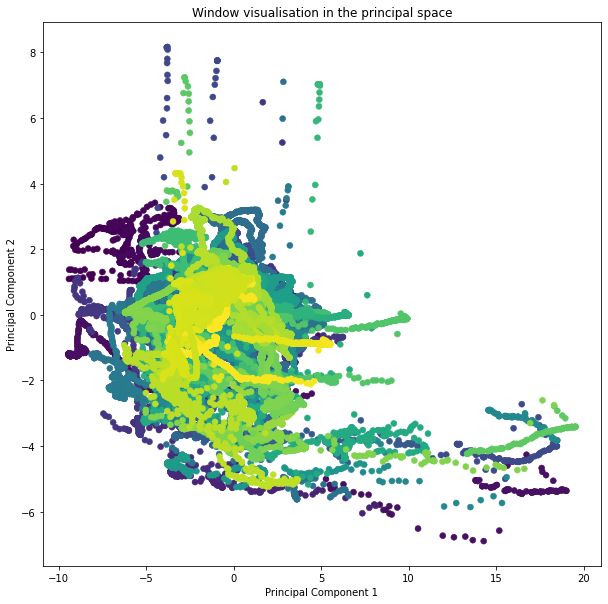

In [91]:
def do_pca(data,nb):
    pca = PCA(n_components=nb)
    results = pca.fit_transform(data)
    return results

def plot_pca(data_pca,title,ax,pred=None) :
    labels = LabelEncoder().fit_transform(data['day_cycle_window'])
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")

    if pred is not None :
        ax.scatter(data_pca[:,0],data_pca[:,1], s=4, lw=0)
        # Plot circles around the predicted outliers
        ax.scatter(data_pca[pred==-1, 0], data_pca[pred==-1, 1], 
           lw=3, facecolors="none", edgecolors="r", s=80, label="predicted outlier")
    else :
        ax.scatter(data_pca[:,0],data_pca[:,1], c=labels, linewidths= 0.5)

    ax.set_title(title)


data_pca = do_pca(data.drop('day_cycle_window',axis=1),2)
fig, ax = plt.subplots(figsize=(10,10))
plot_pca(data_pca,"Window visualisation in the principal space",ax)

We observe that the windows look alike despite some irregularities. The purple window seems a little different since it's a little to the left contrary to the others. We also note that some windows have values in the left bottom cornor.  
Plus, in the middle, all points are superimposed, which means that there could be windows that show irregularities but are hidden by the other windows. It is thus important to implement an algorithm that will automatically detect outliers.

# Choice of anomaly detection method

## I. Feature extraction
We know how to classify a point as an anomaly or not. However, a window is a set of 100 points. The idea is to aggregate those 100 points into a set of features. This operation is called feature extraction

### 1. Naive approach
The first idea is to reduce those 100 points into one point using the mean of each vaiable in each window.

In [92]:
data_reduced = data.groupby(['day_cycle_window']).mean()

data_reduced.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
day_cycle_window,,,,,,,,,,,
1_1_1,-1.926141,-2.456284,-2.487394,-2.481230,-2.388674,-1.984092,-2.447148,-1.169837,2.848242,-1.370045,-2.500060
1_1_10,1.204735,1.123558,1.077596,1.128253,1.136183,1.228688,1.199106,1.308412,-0.429810,-0.088168,1.016565
1_1_11,0.742475,0.703459,0.680578,0.740626,0.768269,0.736631,0.755362,0.783155,-0.429810,-0.091129,0.669938
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.429810,-0.085217,0.303699
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.429810,-0.089727,0.186059


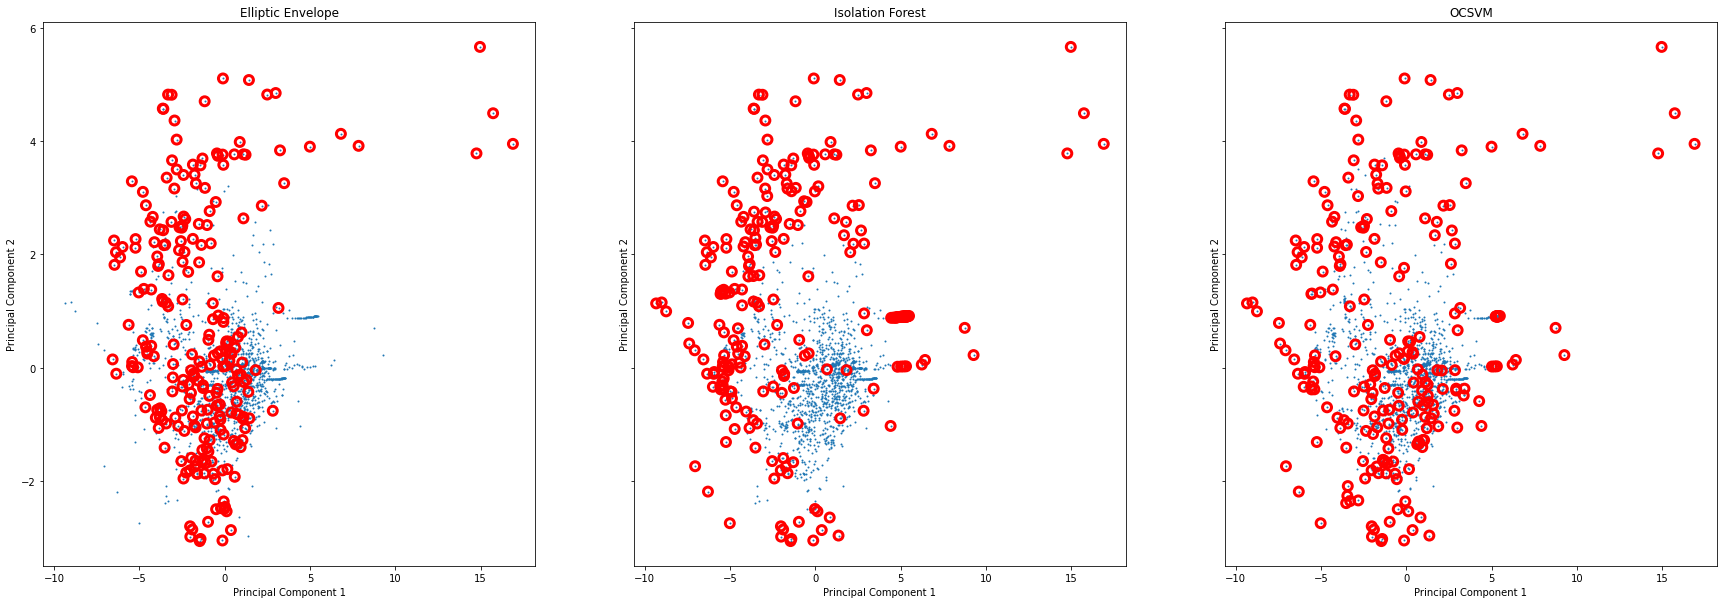

In [93]:
data_reduced_pca = do_pca(data_reduced,2)

_, ax = plt.subplots(1,3, sharey=True, figsize=(30,10))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(data_reduced)
    pred = clf.predict(data_reduced)
    plot_pca(data_reduced_pca,clf_name,ax[i], pred=pred)


This seems to work, however using only the mean to aggregate a series of 100 points leads to a huge loss of information because the mean is not necessarily representative of our data.

### 2. A better approach
Instead of computing the mean, we can extract many other useful characteristics from each window's variable whose points form a sequence or a `time series`. 
We can use the library `tsfresh` to calculate time series features, however we will only use the `mean`, `median`, `maximum`, `minimum`, `standard deviation` and the `number of peaks`. These features are the most used in the litterature.

In [94]:
from scipy.signal import find_peaks

def num_peaks(seq):
    '''Function that calculates the number of peaks in a series'''
    return len(find_peaks(seq)[0])

In [95]:
data_reduced = data.groupby(['day_cycle_window']).agg(['median','mean','std','max','min',num_peaks])

data_reduced.head()

p1                                                    \
                    median      mean       std       max       min num_peaks   
day_cycle_window                                                               
1_1_1            -1.849016 -1.926141  0.591155 -0.805191 -3.107670         2   
1_1_10            1.118294  1.204735  0.245958  1.582127  0.900633         1   
1_1_11            0.800962  0.742475  0.133627  0.900633  0.486868         0   
1_1_12            0.290764  0.300162  0.089126  0.486868  0.169069         0   
1_1_13            0.137776  0.140935  0.006691  0.161408  0.137776         0   

                        p2                                ...       p10  \
                    median      mean       std       max  ...       std   
day_cycle_window                                          ...             
1_1_1            -2.565392 -2.456284  0.739638 -1.112276  ...  0.673869   
1_1_10            1.037859  1.123558  0.242592  1.528097  ...  0.007340   
1_1_11            0.751052  0.703459  0.132878  0.855591  ...  0.007835   
1_1_12            0.280503  0.289058  0.077160  0.441402  ...  0.008146   
1_1_13            0.150402  0.152487  0.004849  0.167603  ...  0.008337   

                                                     p11                      \
                       max       min num_peaks    median      mean       std   
day_cycle_window                                                               
1_1_1             0.495528 -2.283434        10 -2.857906 -2.500060  0.724468   
1_1_10           -0.070064 -0.107307        19  0.916551  1.016565  0.211292   
1_1_11           -0.075944 -0.106327        11  0.722549  0.669938  0.121043   
1_1_12           -0.068104 -0.101053         9  0.293052  0.303699  0.068842   
1_1_13           -0.070064 -0.103387        10  0.182155  0.186059  0.005184   

                                                
                       max       min num_peaks  
day_cycle_window                                
1_1_1            -1.244472 -3.183571         2  
1_1_10            1.437874  0.807778         1  
1_1_11            0.807778  0.450576         0  
1_1_12            0.450576  0.208743         0  
1_1_13            0.197741  0.179901         2  

[5 rows x 66 columns]

Now we use three different anomaly classifiers on our reduced dataset and we observe the anomalies in the principal space.

As a reminder : The classifiers are :
* Elliptic Envelope: EllipticEnvelope(contamination=0.15),
* Isolation Forest : IsolationForest(n_estimators=100, contamination=0.15),
* OCSVM            : OneClassSVM(nu=0.15, kernel="rbf", gamma=0.3),

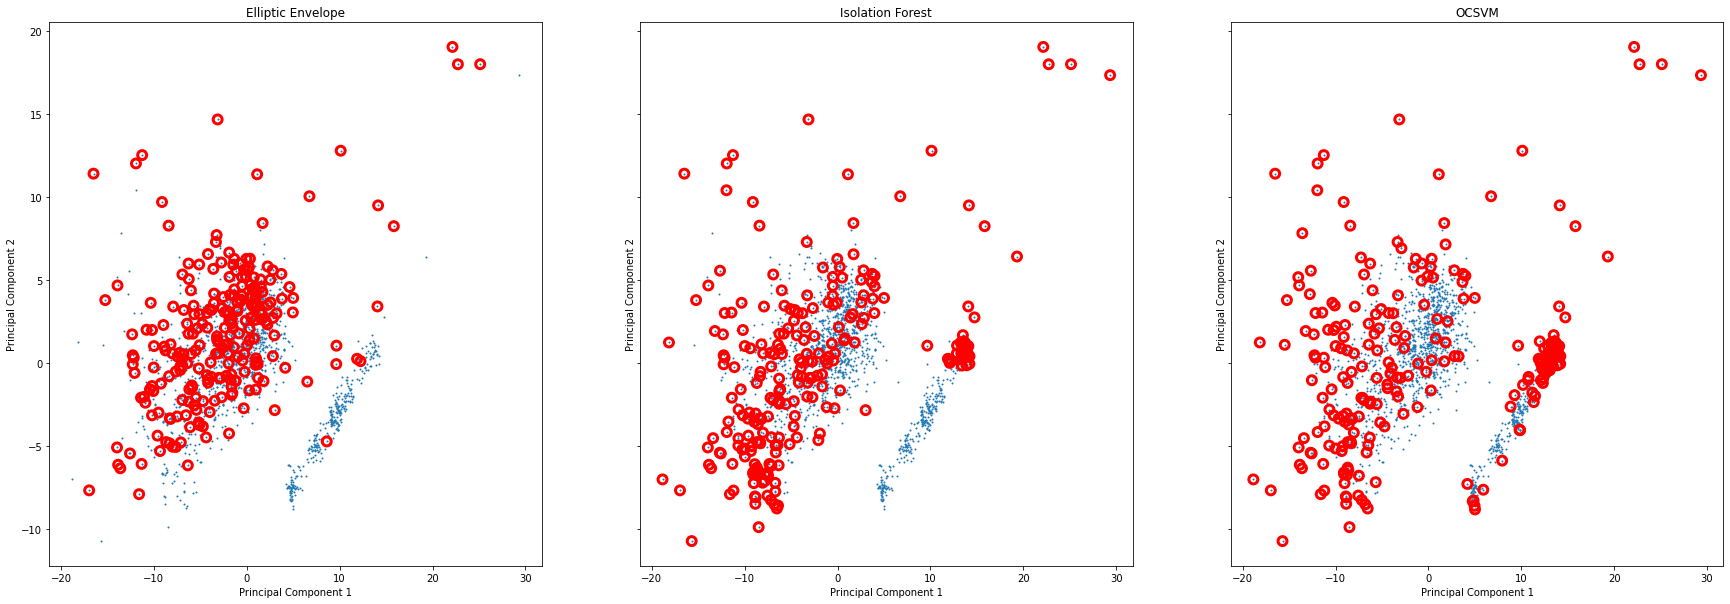

In [96]:
data_reduced_pca = do_pca(data_reduced,2)

_, ax = plt.subplots(1,3, sharey=True, figsize=(30,10))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(data_reduced)
    pred = clf.predict(data_reduced)
    plot_pca(data_reduced_pca,clf_name,ax[i],pred=pred)

We choose this method because it is more accurate than the first. The more features we extract the better we represent the dataset.

OCSVM seems to detect much more outliers than Elliptic Envelope and Isolation Forest. The aligned data on the right are all detected as anomalies by OCSVM. However, we know that OCSVM is very sensitive to threshold and choice of kernel. It is important to first fine-tune the hyperparameters of each model then choose the best one. 

## II. Choice of scale
An idea is to compare windows at different scales. For example, given that the flight conditions might change from day to day (or during a day), it is interesting to compare windows that have similar conditions, ie. that belong to the same day (or cycle). This will allow us to avoid biases due to our lack of knowledge of the variables recordings and conditions.

### 1. Anomaly detection in each day 
We compare windows belonging to the same day.

In [97]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data.drop('day_cycle_window',axis=1))

explainability = pca.explained_variance_ratio_

print('Explainability of 2 principal components : ', np.sum(explainability))

Explainability of 2 principal components :  0.7428154944339287


The explainability is not high enough to only focus on the 2 higher principal components. Thus, PCA will only be a way to visualize results but the algorithms will be run on every dimension if the dataset. 

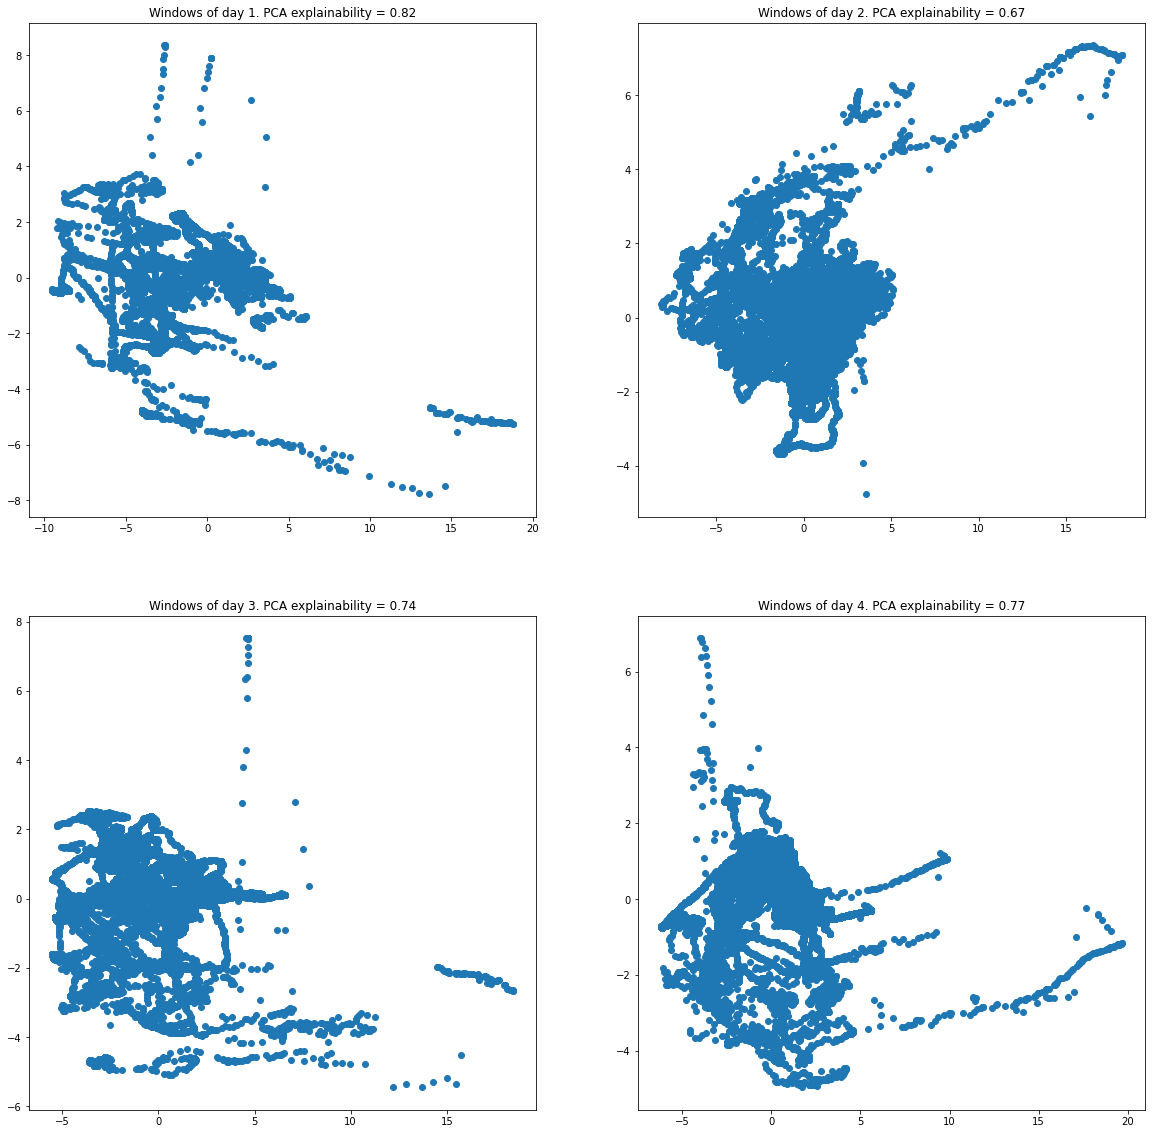

In [98]:
## Visualization day by day

data_splitted = data.copy()
data_splitted[['day','cycle','window']] = data_splitted['day_cycle_window'].str.split(pat="_",expand=True)

_, axes = plt.subplots(2, 2, figsize = (20,20))

pca = PCA(n_components=2)

for i in range(4):
    day = i+1

    data_pca = data_splitted[data_splitted['day'] == str(day)]
    data_pca = data_pca.drop(['day_cycle_window','day','cycle','window'],axis=1)

    res = pca.fit_transform(data_pca)

    PCA_score = np.sum(pca.explained_variance_ratio_)

    axes[i//2, i%2].plot(res[:,0], res[:,1], 'o')
    axes[i//2, i%2].set_title('Windows of day ' + str(i+1) + '. PCA explainability = %0.2f' % PCA_score)


It is here interesting to notice that the PCA variability percentage and the shape of the data are not changing a lot depending on the day we are looking at, except for day 2 where both shape and percentage of variability differ from the other days. It seems worth taking an interest in this scale.

Let's group the dataset by day :

In [99]:
data_reduced = data_reduced.reset_index()
#We create three variables : day, cycle and window.
data_reduced[['day','cycle','window']] = data_reduced['day_cycle_window'].str.split(pat="_",expand=True)

data_reduced.head()

day_cycle_window        p1                                          \
                      median      mean       std       max       min   
0            1_1_1 -1.849016 -1.926141  0.591155 -0.805191 -3.107670   
1           1_1_10  1.118294  1.204735  0.245958  1.582127  0.900633   
2           1_1_11  0.800962  0.742475  0.133627  0.900633  0.486868   
3           1_1_12  0.290764  0.300162  0.089126  0.486868  0.169069   
4           1_1_13  0.137776  0.140935  0.006691  0.161408  0.137776   

                   p2                      ...       p10       p11            \
  num_peaks    median      mean       std  ... num_peaks    median      mean   
0         2 -2.565392 -2.456284  0.739638  ...        10 -2.857906 -2.500060   
1         1  1.037859  1.123558  0.242592  ...        19  0.916551  1.016565   
2         0  0.751052  0.703459  0.132878  ...        11  0.722549  0.669938   
3         0  0.280503  0.289058  0.077160  ...         9  0.293052  0.303699   
4         0  0.150402  0.152487  0.004849  ...        10  0.182155  0.186059   

                                          day cycle window  
        std       max       min num_peaks                   
0  0.724468 -1.244472 -3.183571         2   1     1      1  
1  0.211292  1.437874  0.807778         1   1     1     10  
2  0.121043  0.807778  0.450576         0   1     1     11  
3  0.068842  0.450576  0.208743         0   1     1     12  
4  0.005184  0.197741  0.179901         2   1     1     13  

[5 rows x 70 columns]

day :  1


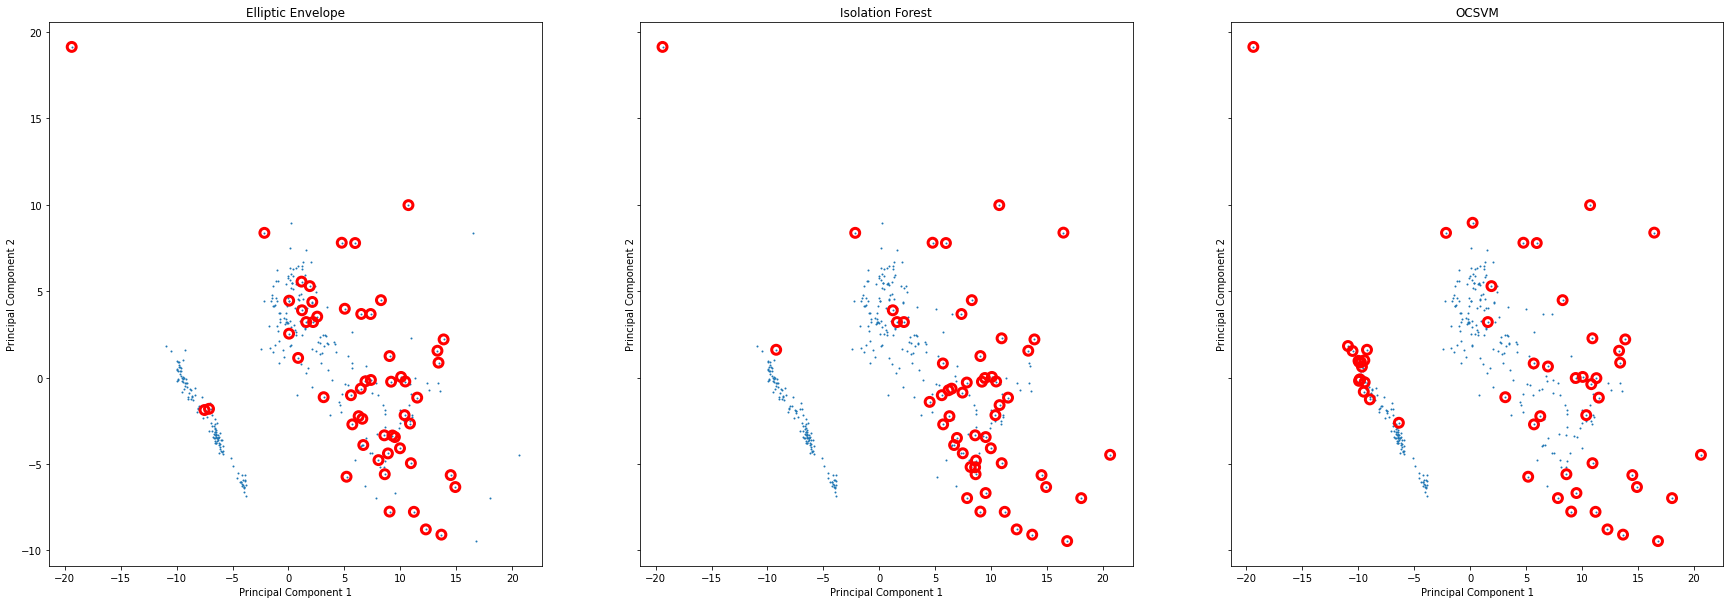

day :  2


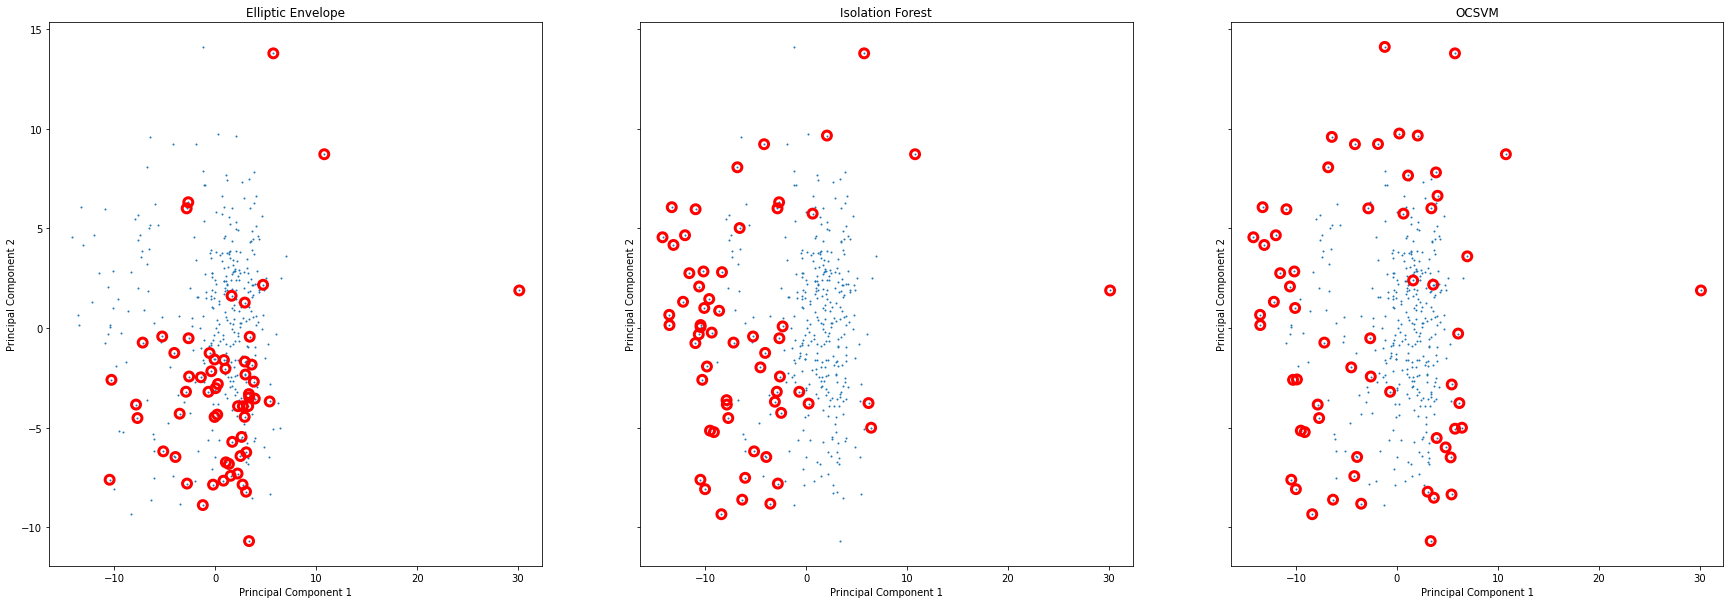

day :  3


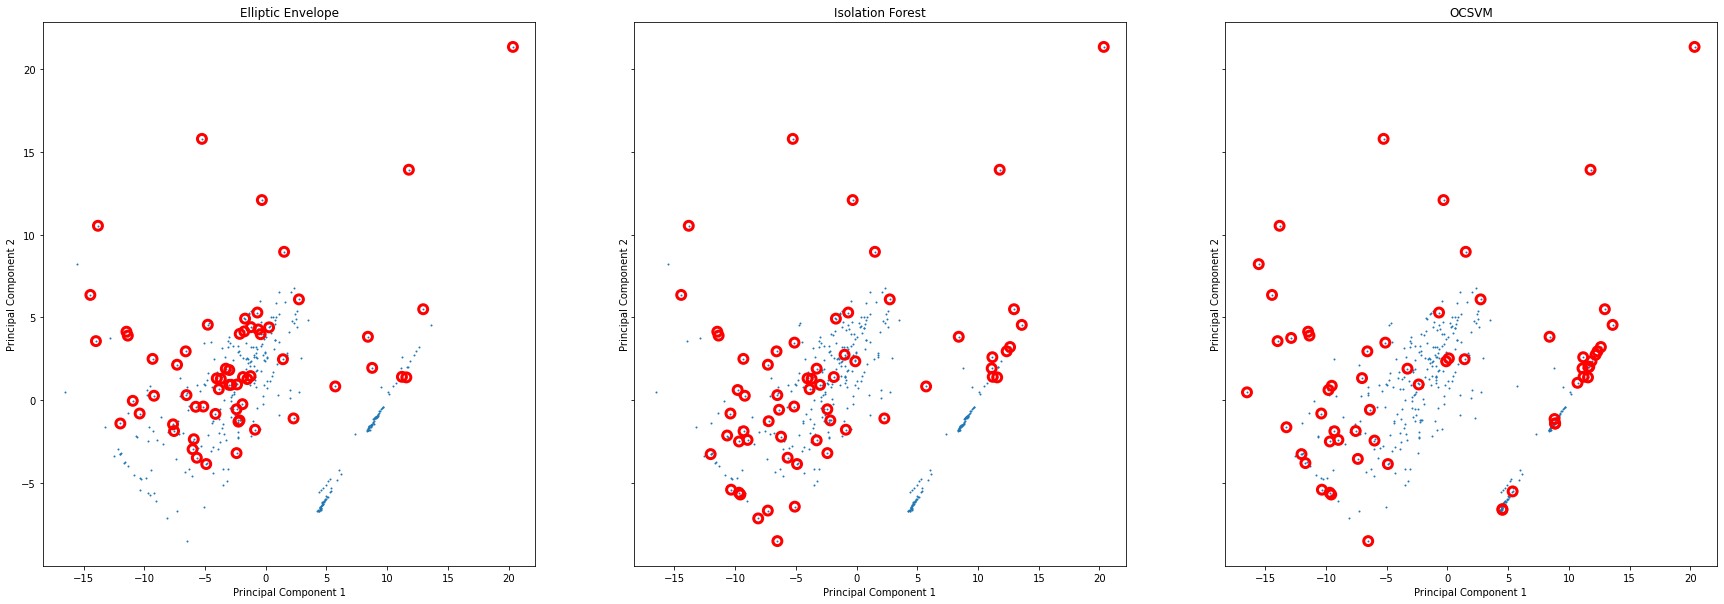

day :  4


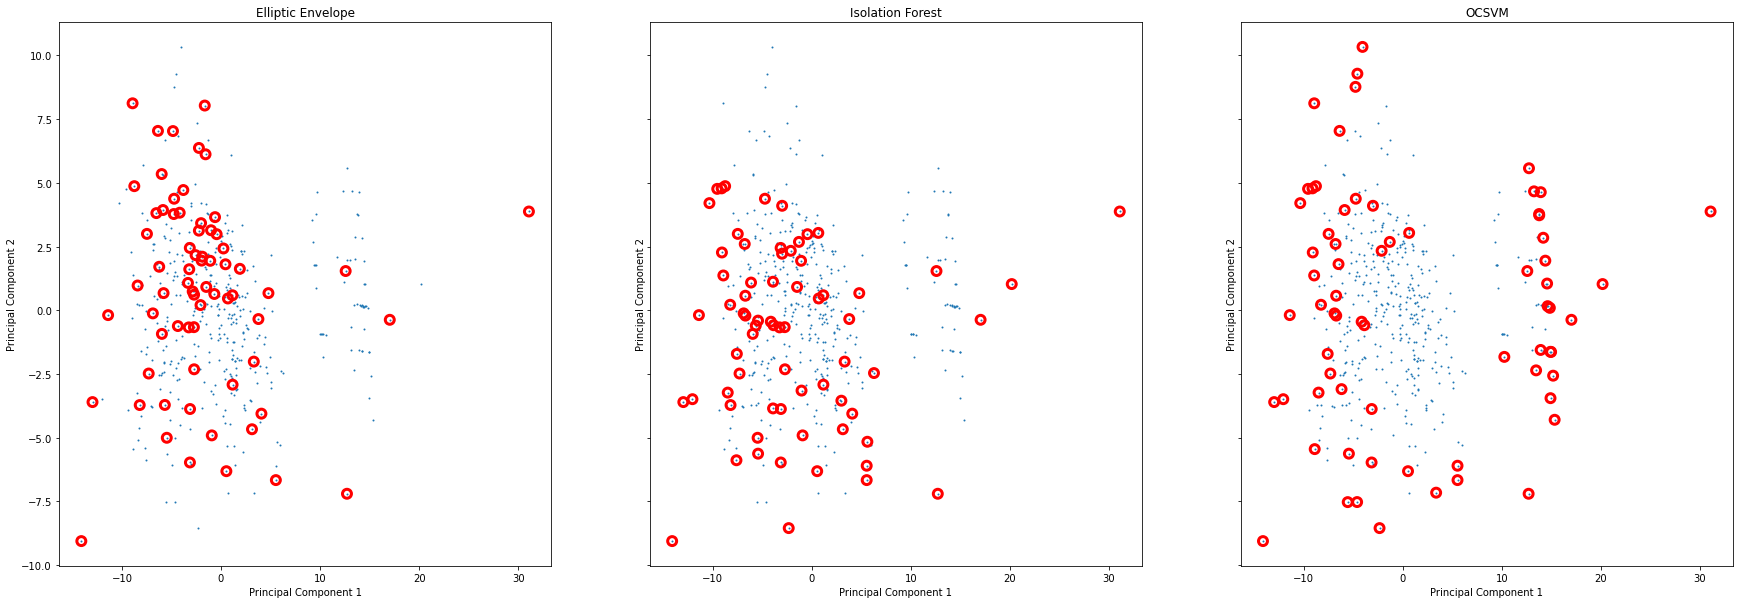

In [100]:
L_anomalies = [[[] for _ in range(4)] for _ in range(len(classifiers.items()))]

for day,df in data_reduced.groupby(['day']):
    df2 = df.drop(columns=['day','cycle','window','day_cycle_window'])
    print("day : ",day)
    df_pca = do_pca(df2,2)

    _, ax = plt.subplots(1,3, sharey=True, figsize=(30,10))

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(df2)
        pred = clf.predict(df2)
        plot_pca(df_pca,clf_name,ax[i],pred=pred)

        L_anomalies[i][int(day)-1].append(np.sum(pred == -1))
    plt.show()
    

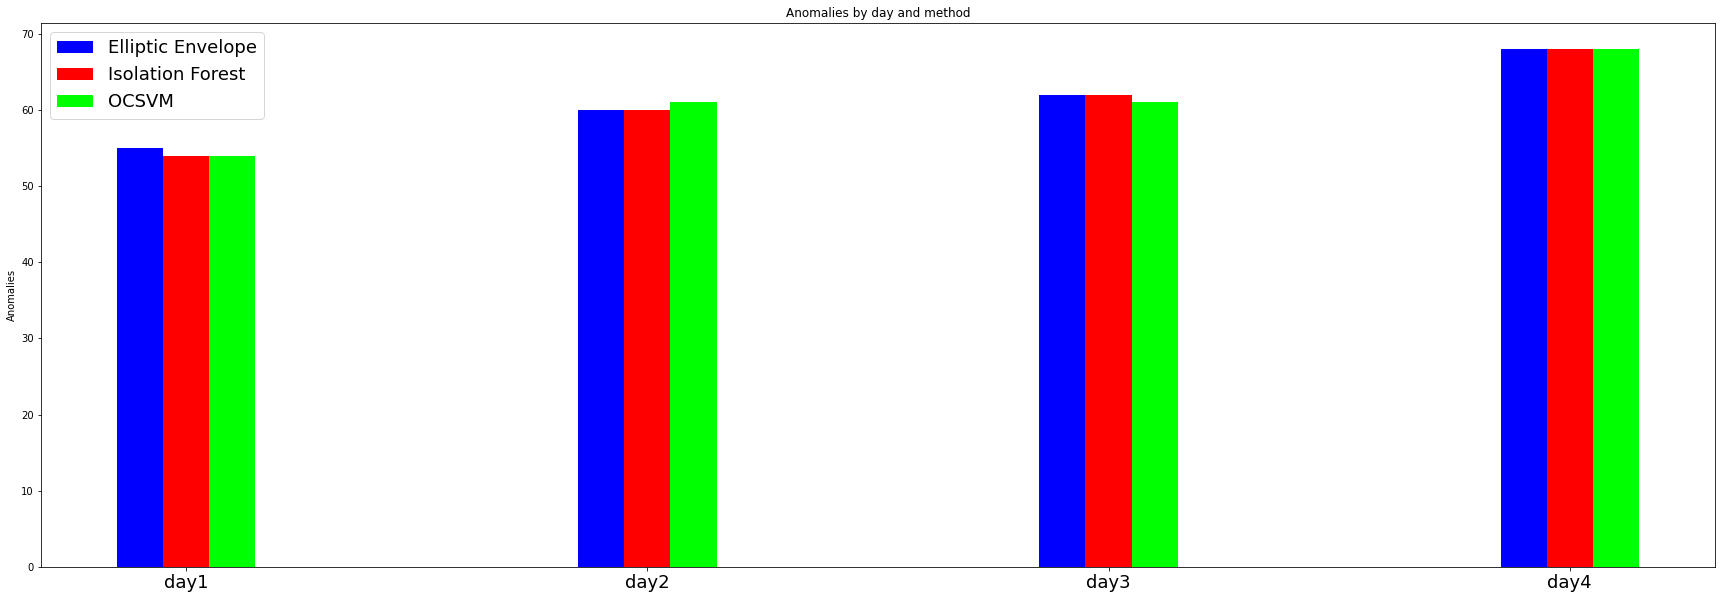

In [101]:
# Visualization of the different days for each method

colors = ['blue', 'red', 'lime']
labels = ['day1', 'day2', 'day3', 'day4']

legend = []


N = 4

ind = np.arange(N)  # the x locations for the groups
width = 0.1        # the width of the bars

fig = plt.figure(figsize = (30,10))
ax = fig.add_subplot(111)

rect_list = []

for i, (clf_name, _) in enumerate(classifiers.items()):
    L_anomalies_flattend = [item for sublist in L_anomalies[i] for item in sublist]
    rect = ax.bar(ind+i*width, L_anomalies_flattend, -width, color=colors[i], align='edge')
    rect_list.append(rect)
    legend.append(clf_name)


# add some
ax.set_ylabel('Anomalies')
ax.set_title('Anomalies by day and method')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels, fontsize=18)

ax.legend( (rect_list[0][0], rect_list[1][0], rect_list[2][0]), legend, fontsize=18)

plt.show()



These graphs show that the number of outliers per day is very similar even when changing the method we use to classify the data. These information will be taken into account when deciding which method should be used and optimized.

### 2. Anomaly detection in each cycle

We compare windows belonging to the same cycle.

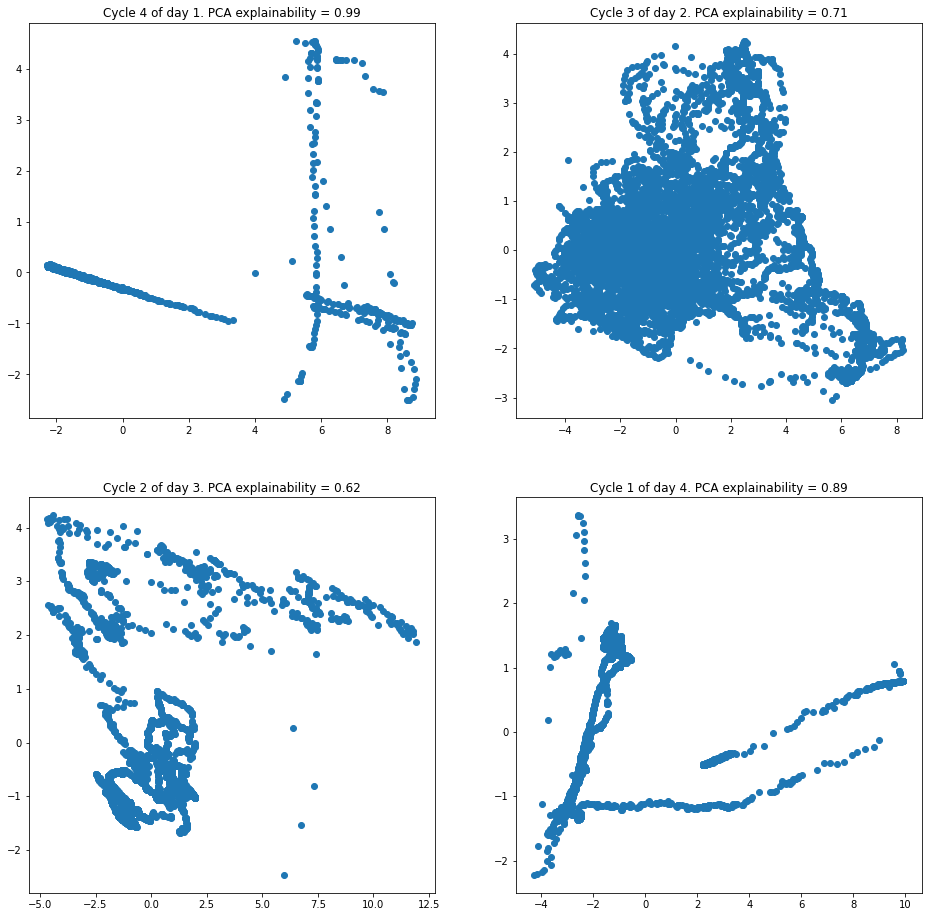

In [102]:
## Vizualisation for a given set of cycles 
_, axes = plt.subplots(2, 2, figsize = (16,16))

pca = PCA(n_components=2)

for i in range(4):
    day = i+1
    cycle = 5 - (i+1)

    data_pca = data_splitted[data_splitted['day'] == str(day)]
    data_pca = data_pca[data_pca['cycle'] == str(cycle)]

    data_pca = data_pca.drop(['day_cycle_window','day','cycle','window'],axis=1)

    res = pca.fit_transform(data_pca)

    PCA_score = np.sum(pca.explained_variance_ratio_)

    axes[i//2, i%2].plot(res[:,0], res[:,1], 'o')
    axes[i//2, i%2].set_title('Cycle ' + str(5-i-1) + ' of day ' + str(i+1) + '. PCA explainability = %0.2f' % PCA_score)


Interesting remarks: it is very variable from one cycle to another, it is worth taking an interest in this scale which is more or less representative in principle.

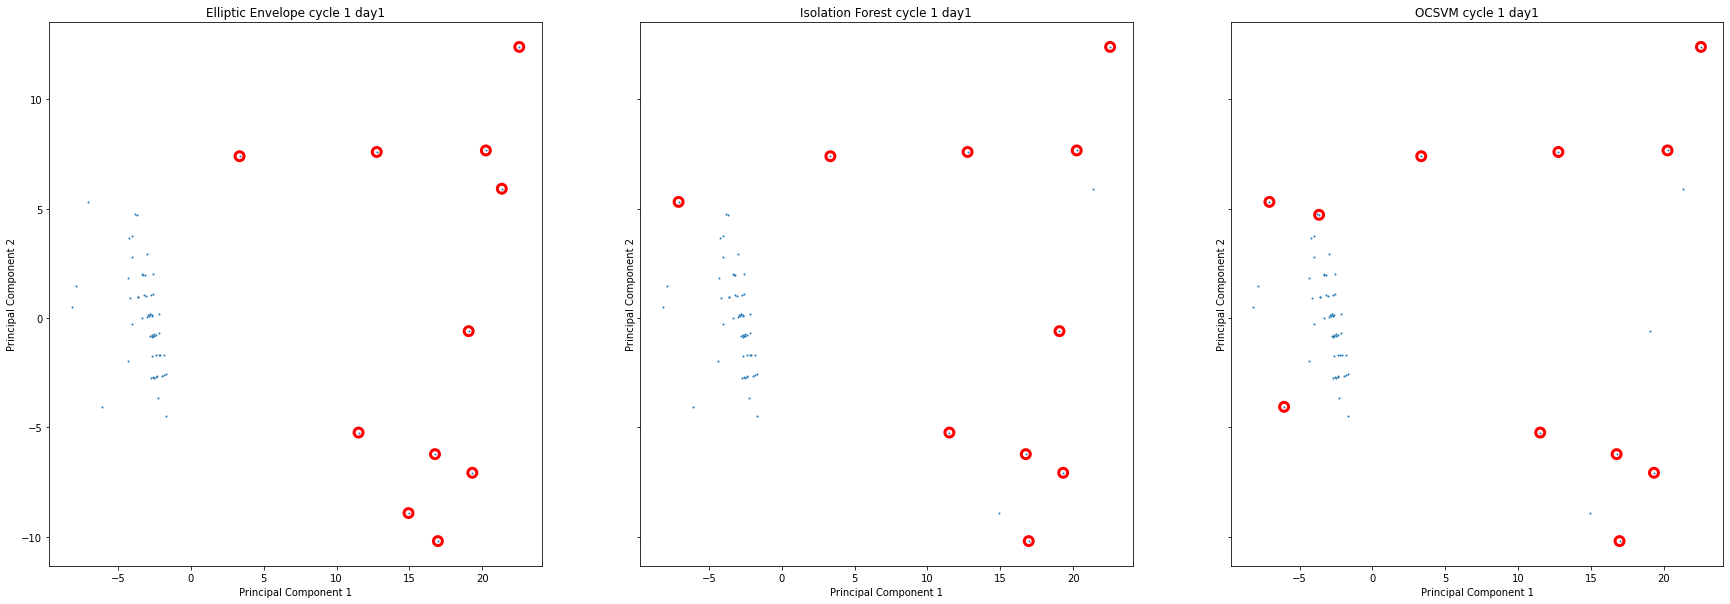

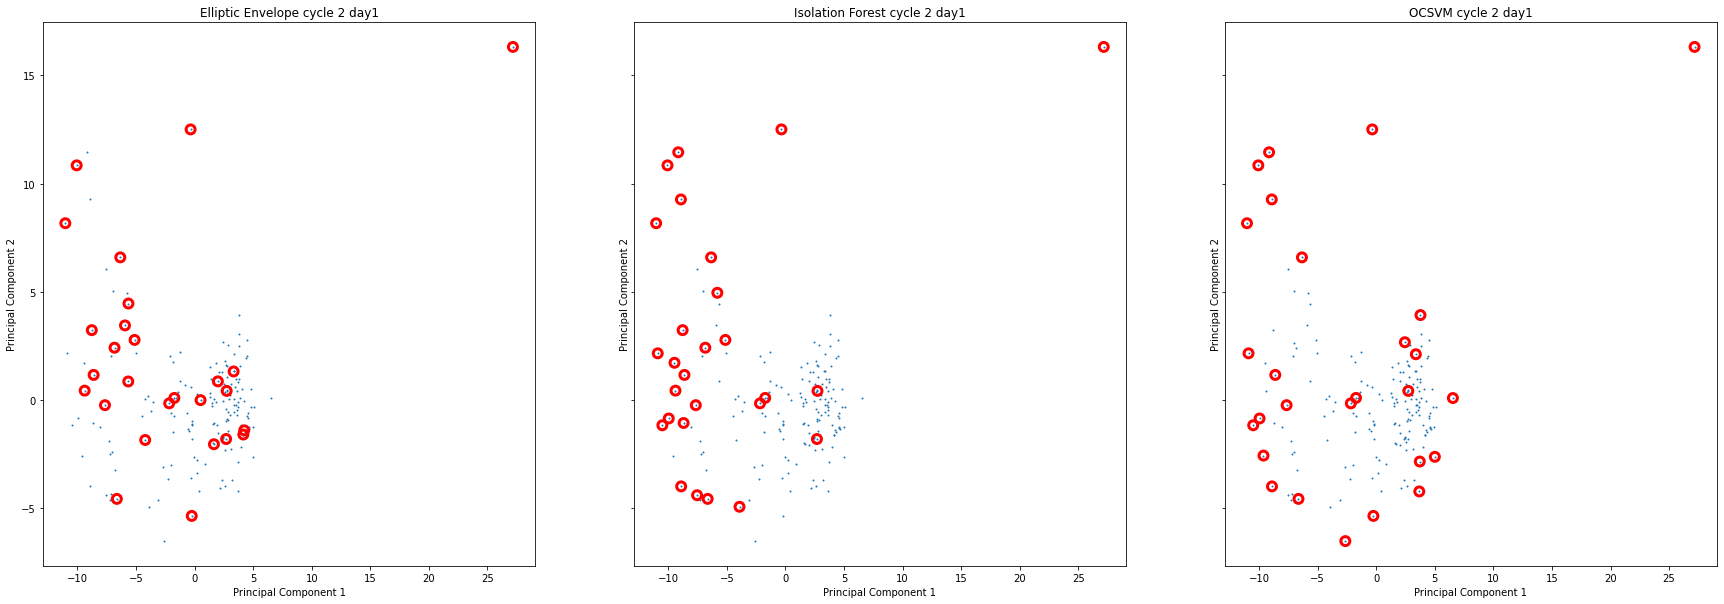

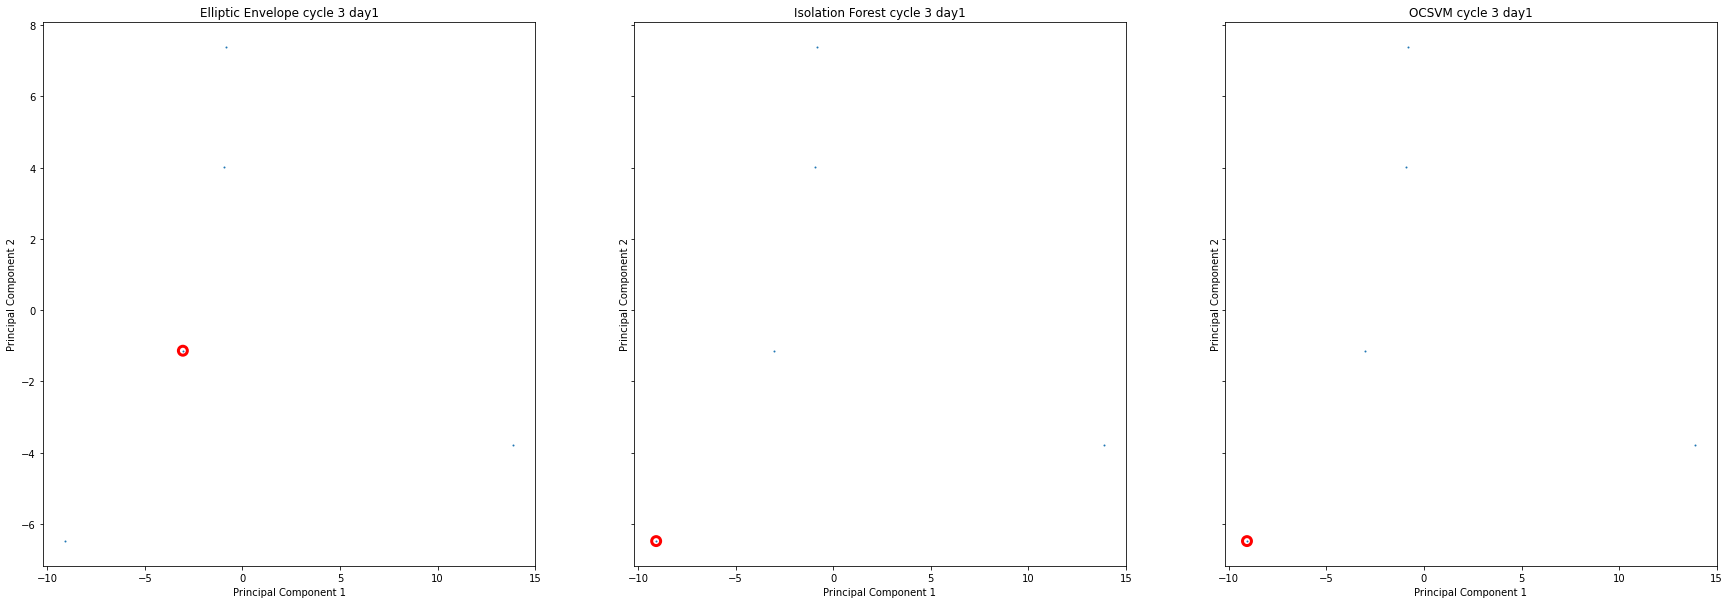

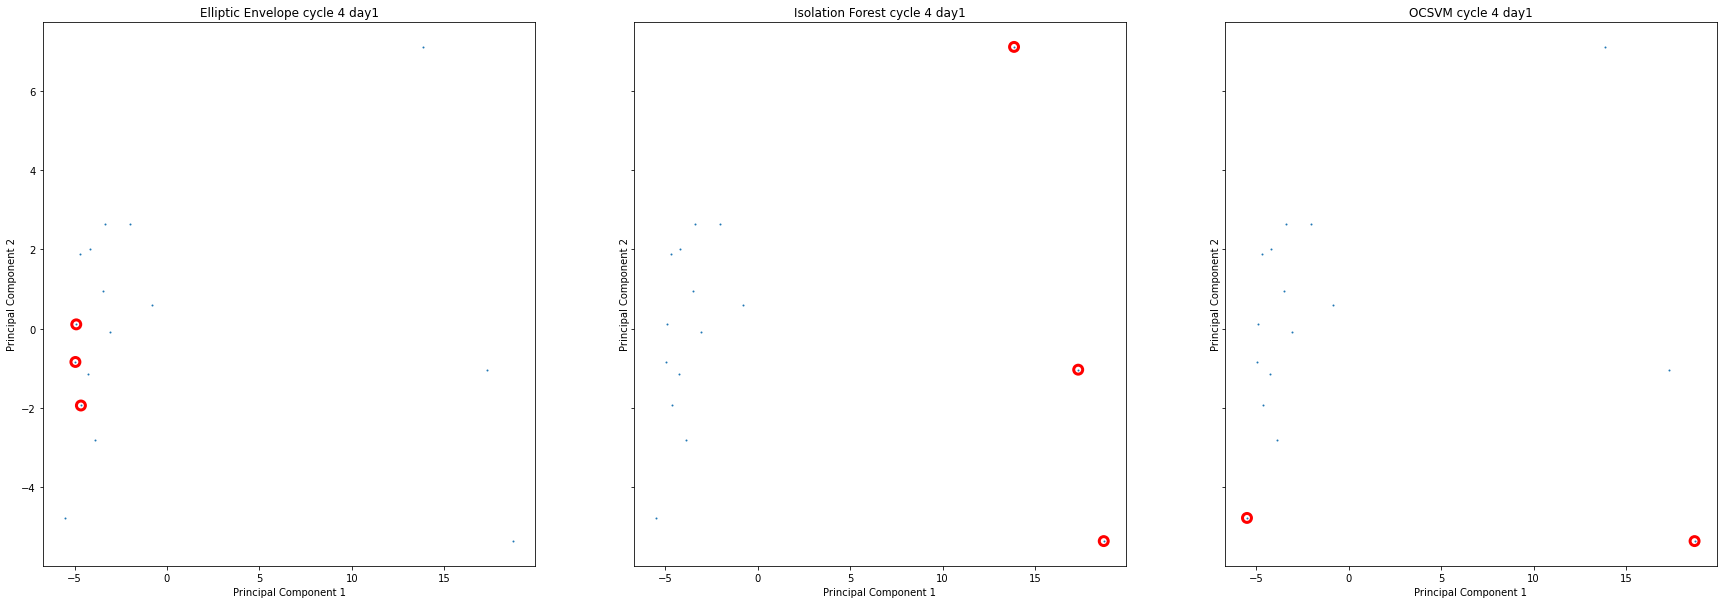

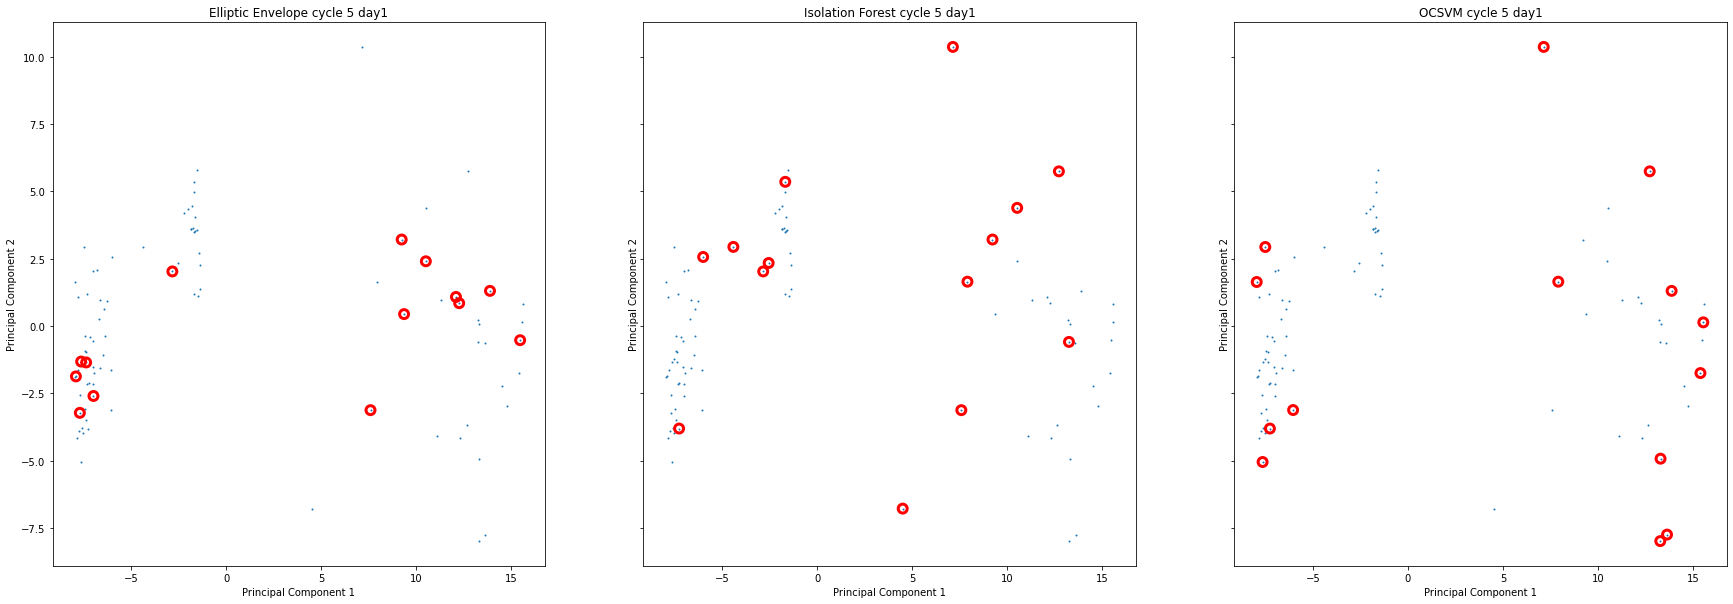

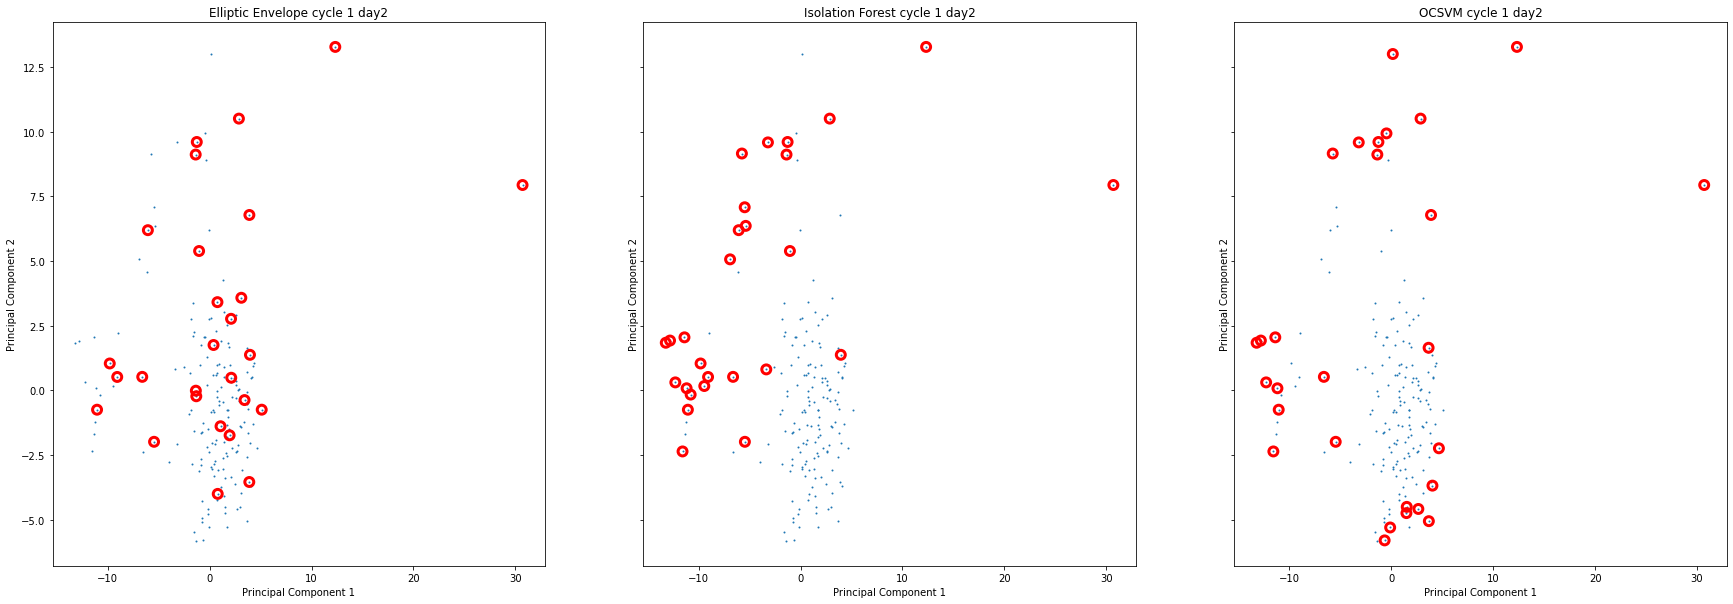

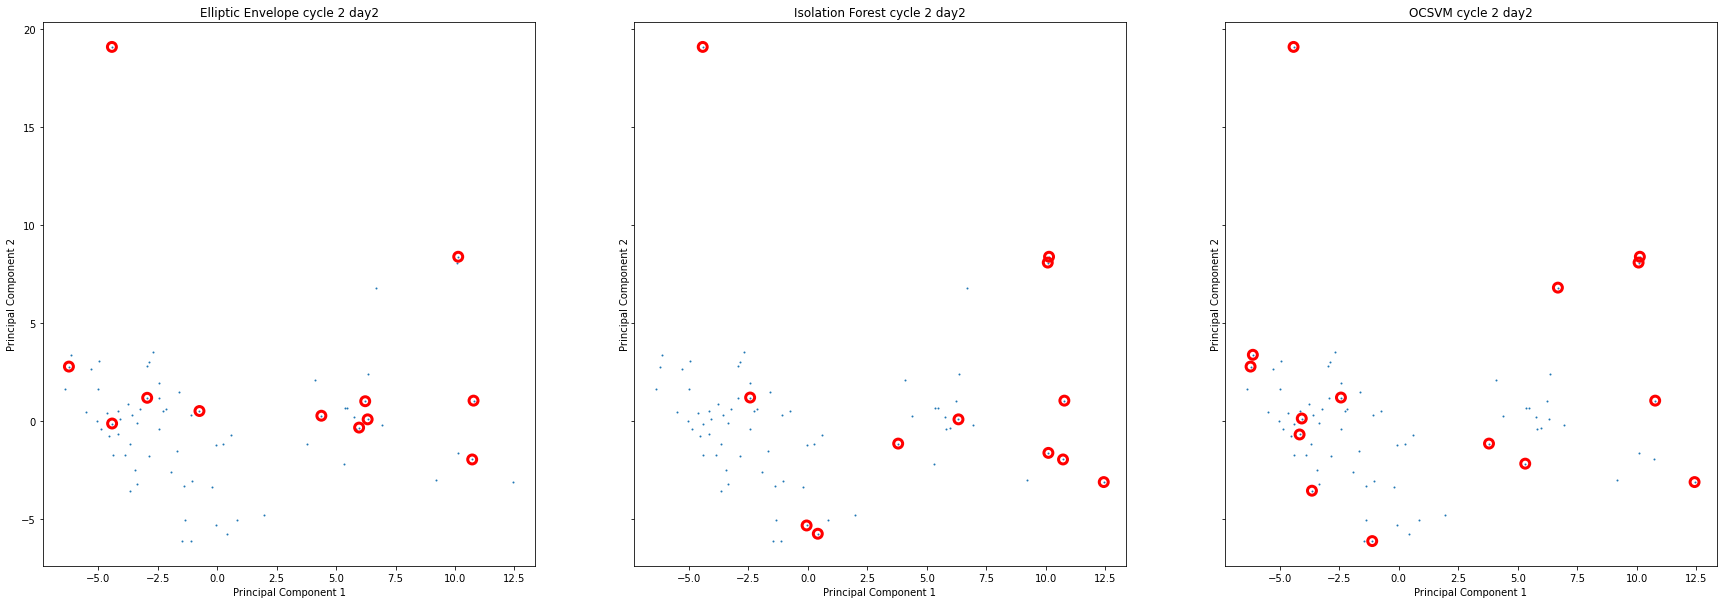

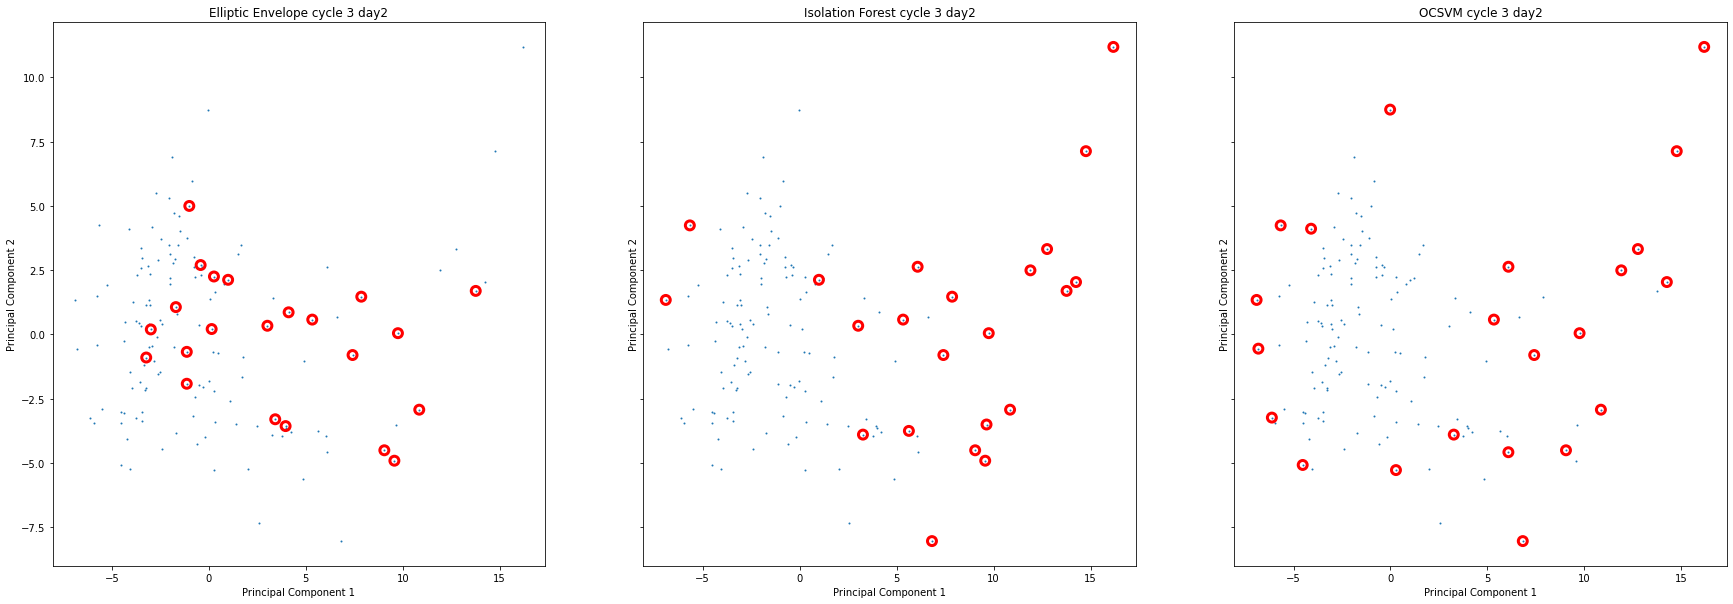

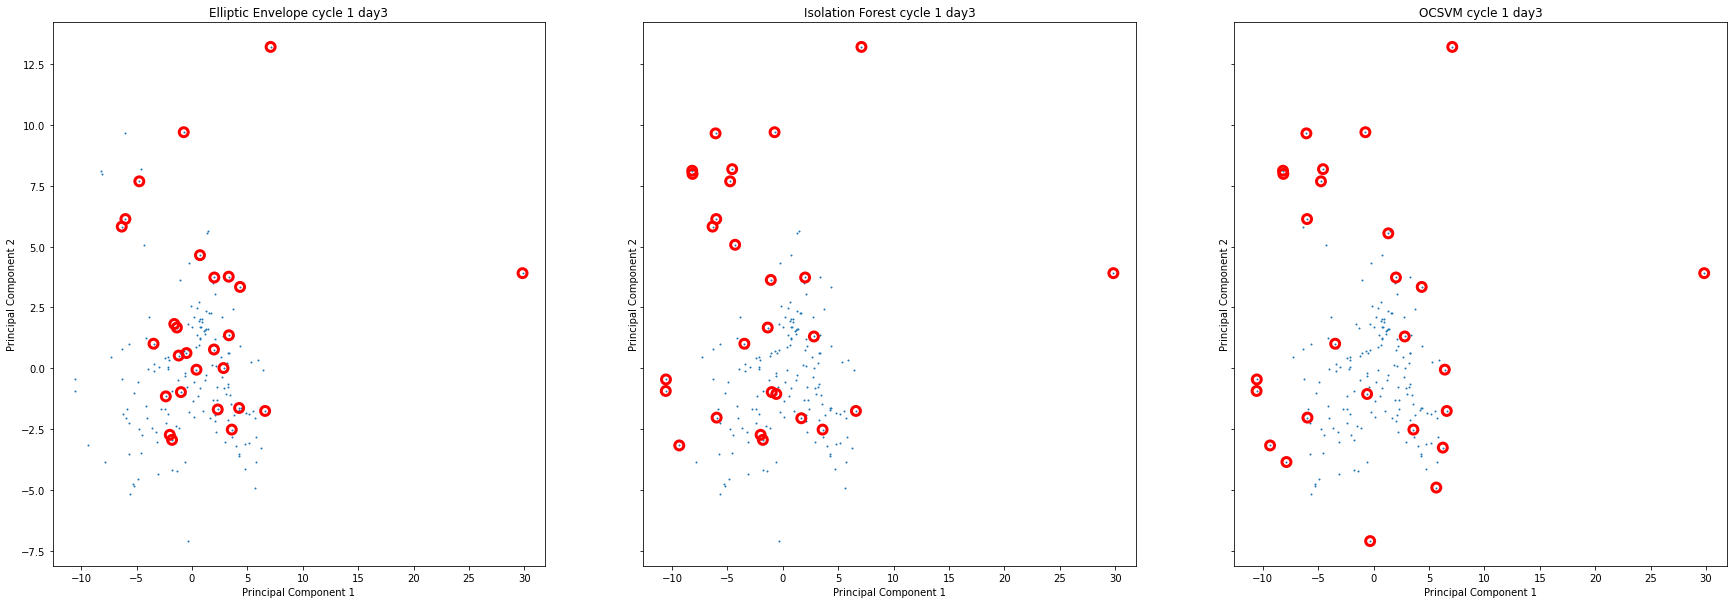

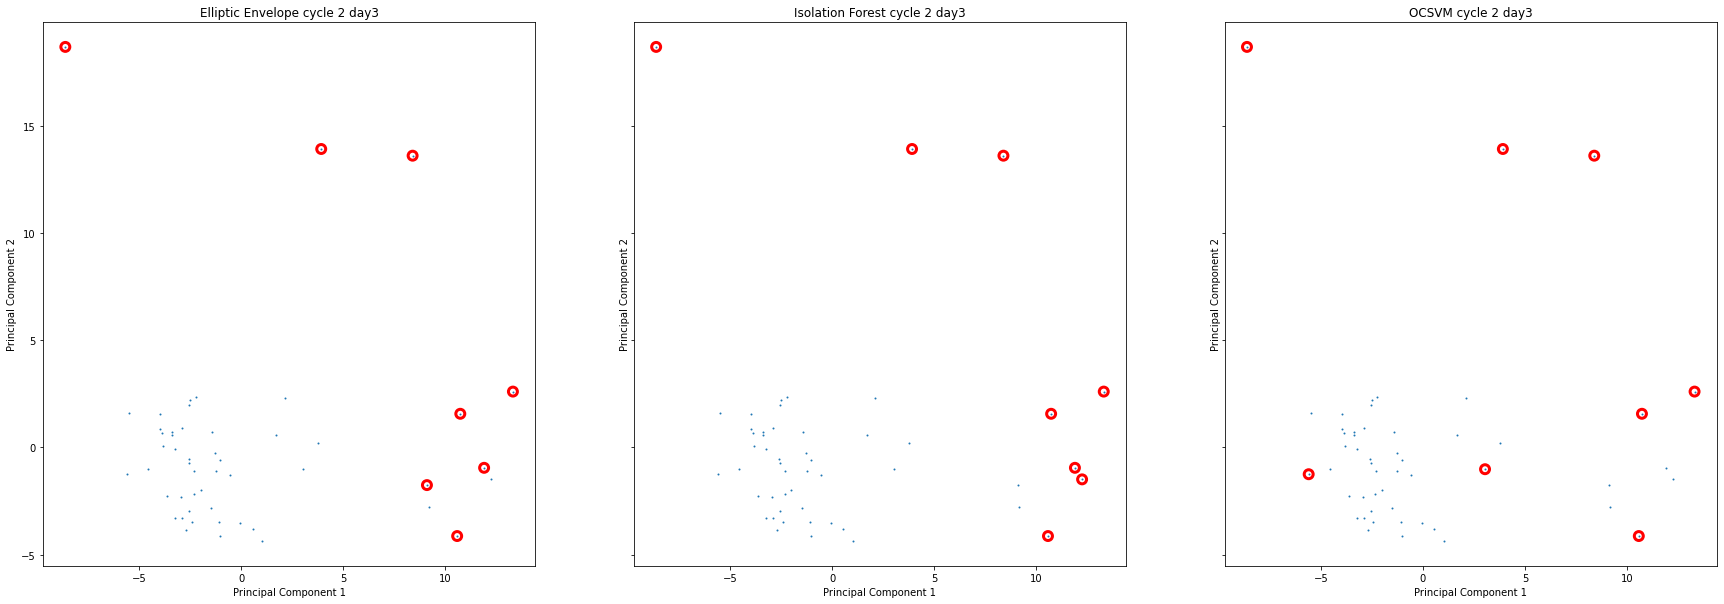

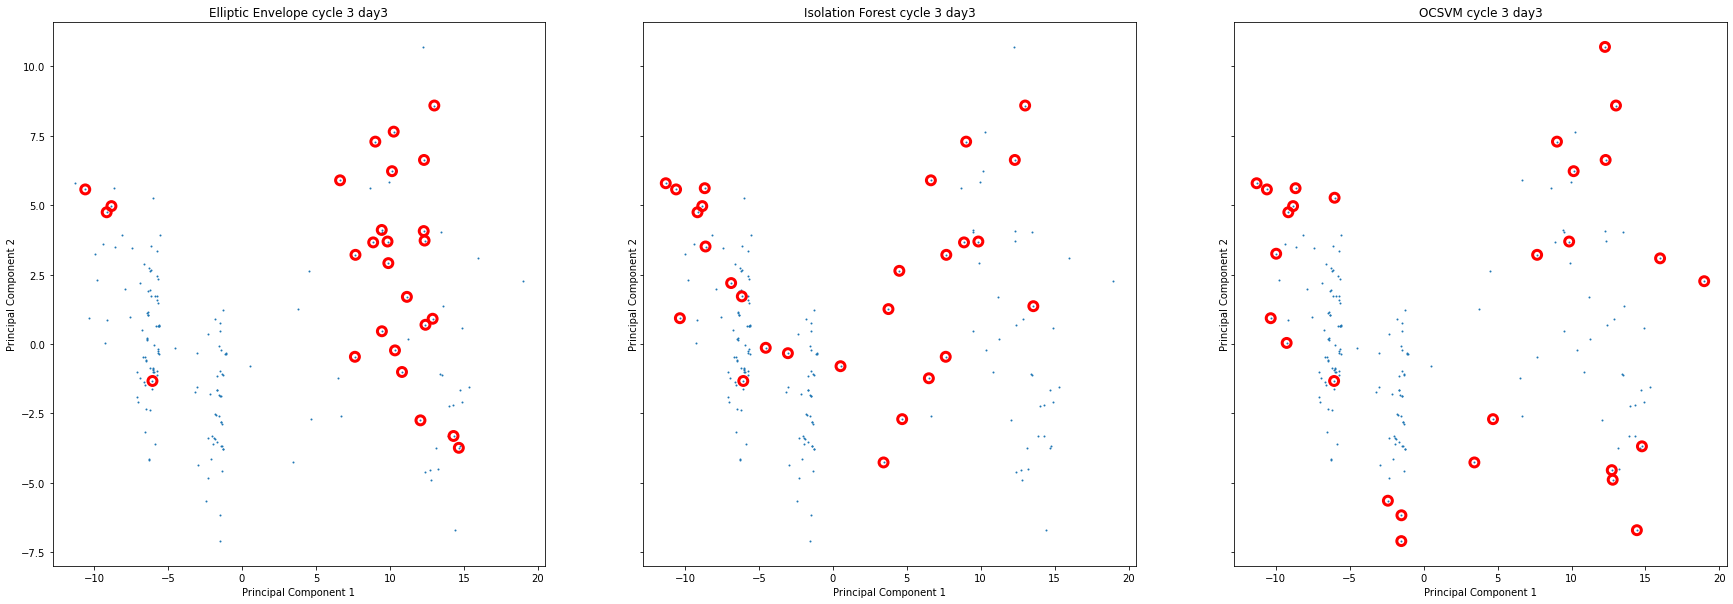

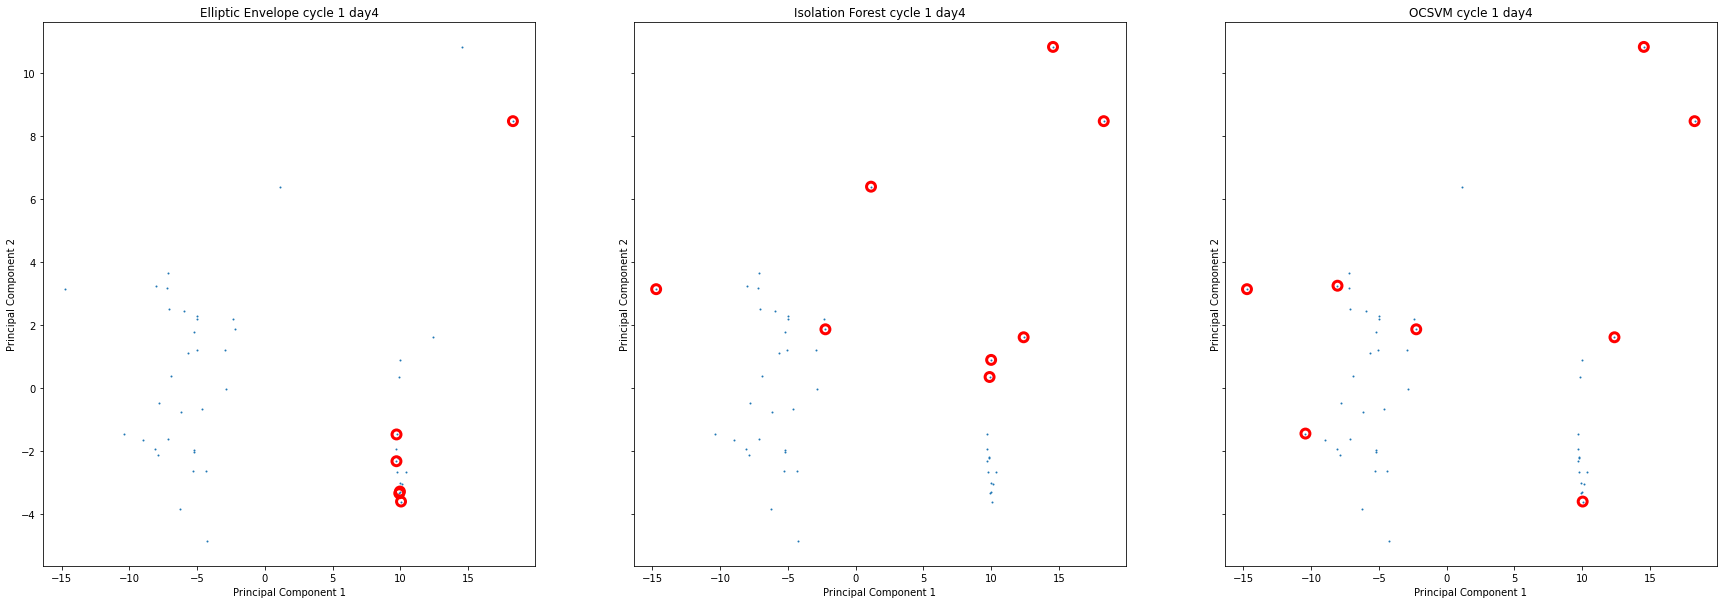

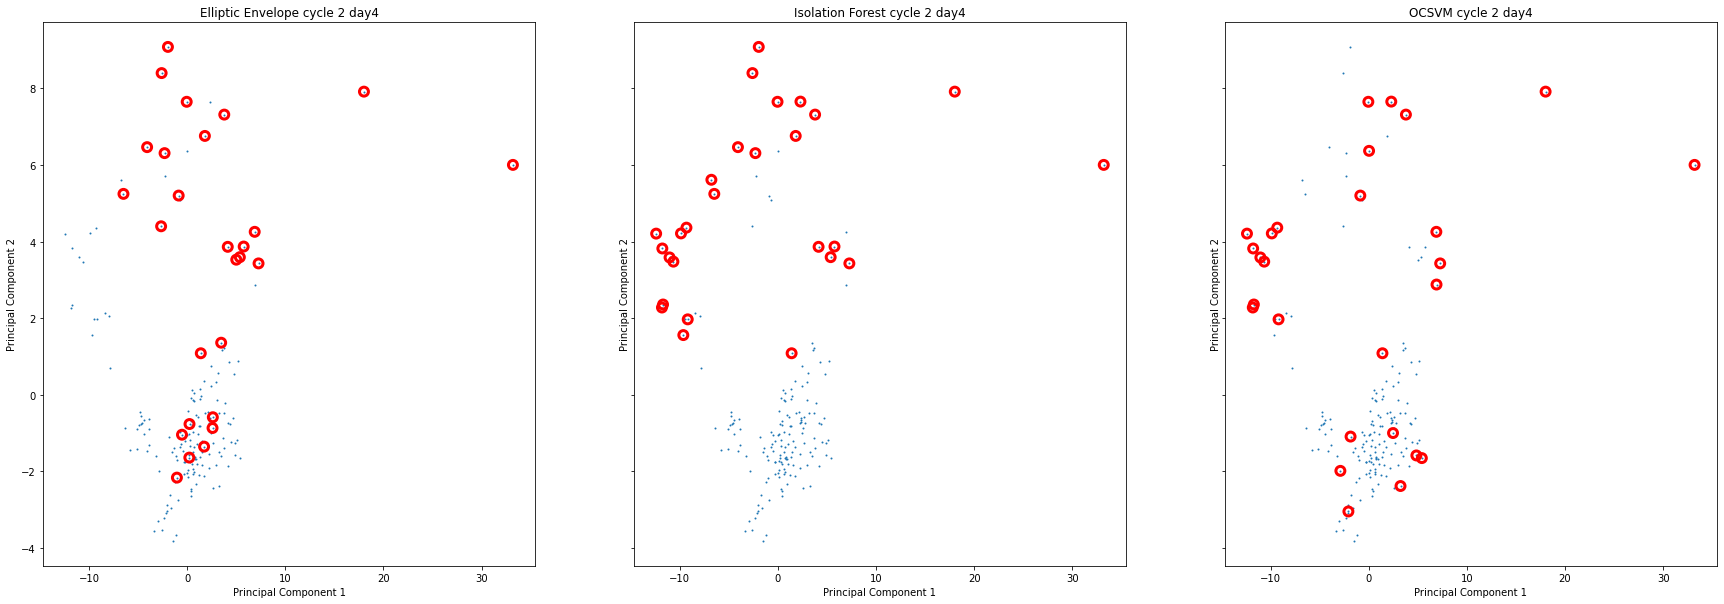

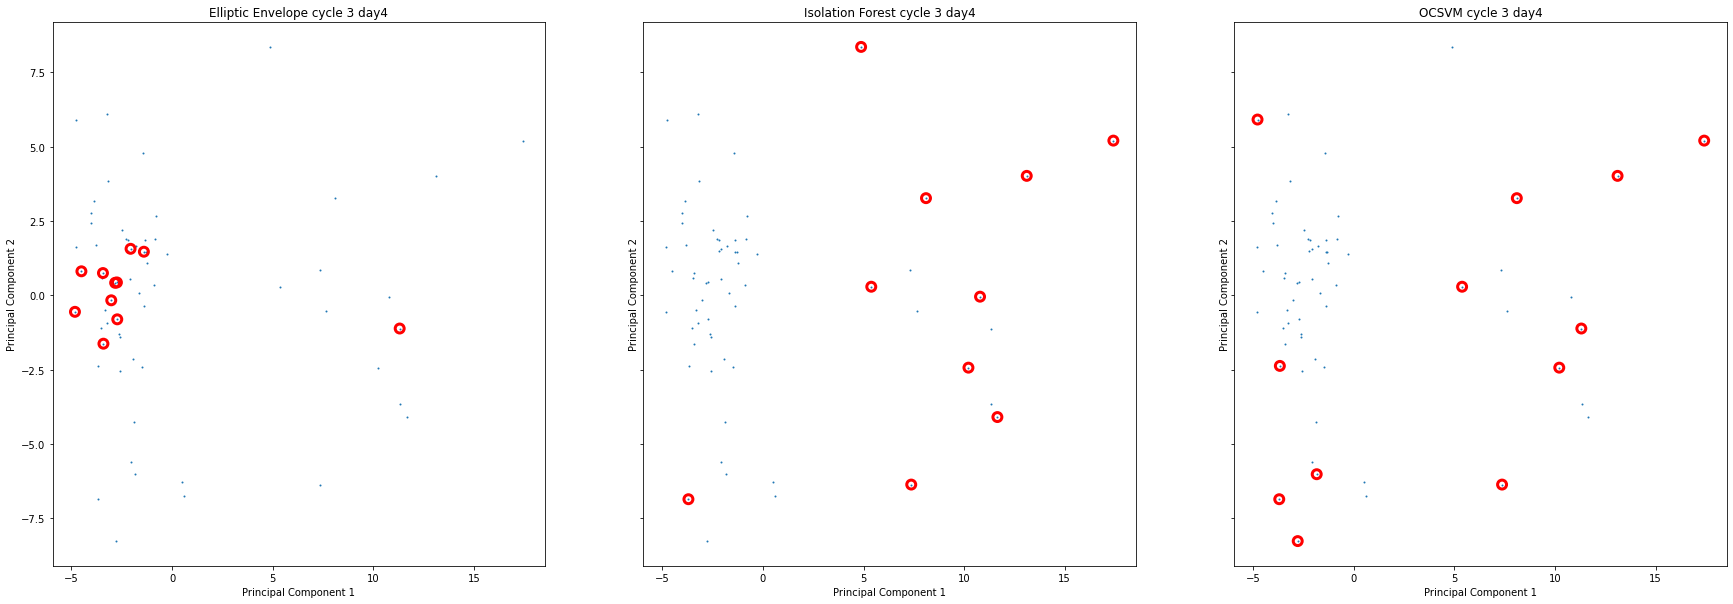

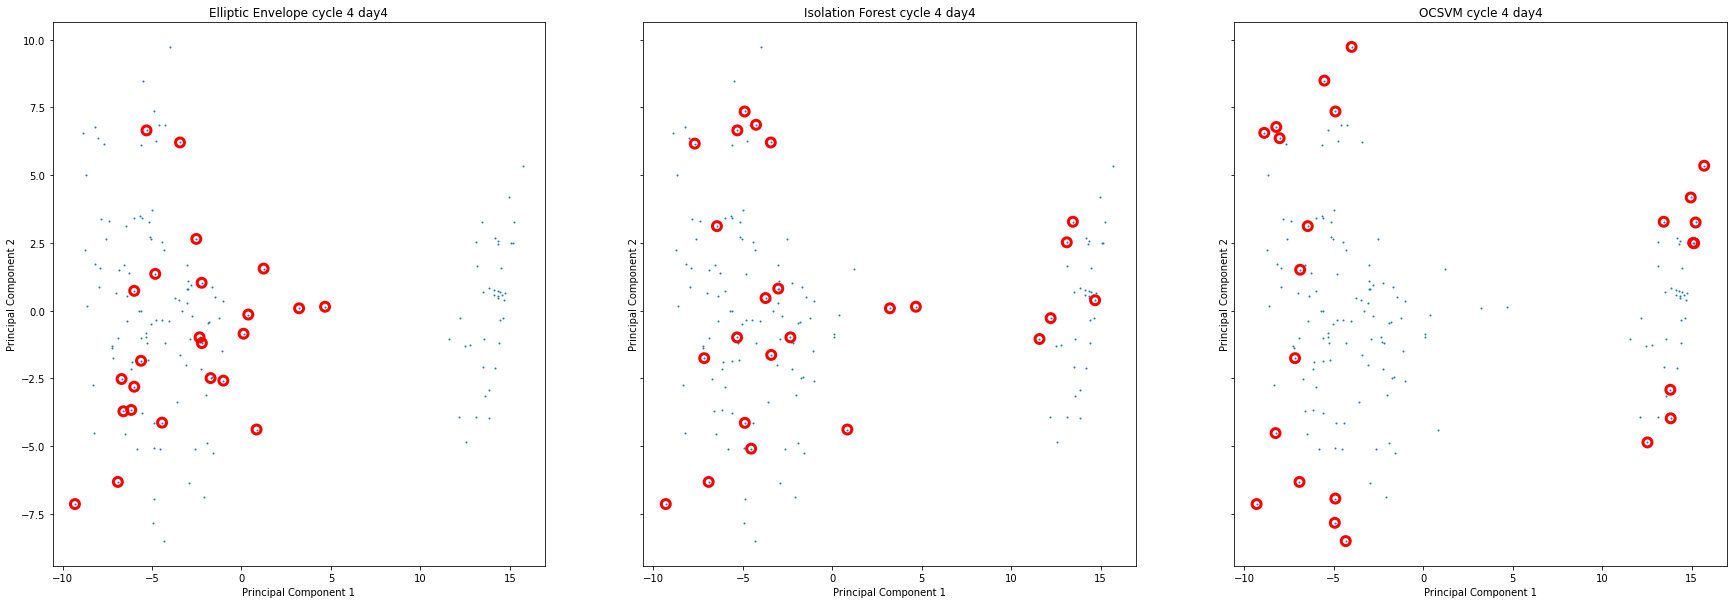

In [103]:
L_anomalies = [[[] for _ in range(4)] for _ in range(len(classifiers.items()))]
pca = PCA(n_components=2)

for (day,cycle),df in data_reduced.groupby(['day','cycle']):
    df2 = df.drop(columns=['day','cycle','window','day_cycle_window'])
    df_pca = pca.fit_transform(df2)
    PCA_score = np.sum(pca.explained_variance_ratio_)
    
    _, ax = plt.subplots(1,3, sharey=True, figsize=(30,10))

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(df2)
        pred = clf.predict(df2)
        plot_pca(df_pca,clf_name+" cycle "+cycle+" day"+ day,ax[i],pred=pred)

        L_anomalies[i][int(day)-1].append(np.sum(pred == -1))
    

This scale is interesting. At this scale the shape of points is delimited and dense making the detection of anomalies easy even visually. However, there are cycles that have very few windows compared to others, for example day1-cycle3 has only 6 windows wheras day2-cycle1 has 181 windows. This adds errors to our anomaly detection.  
**We choose to stick to the day-by-day anomaly detection**.


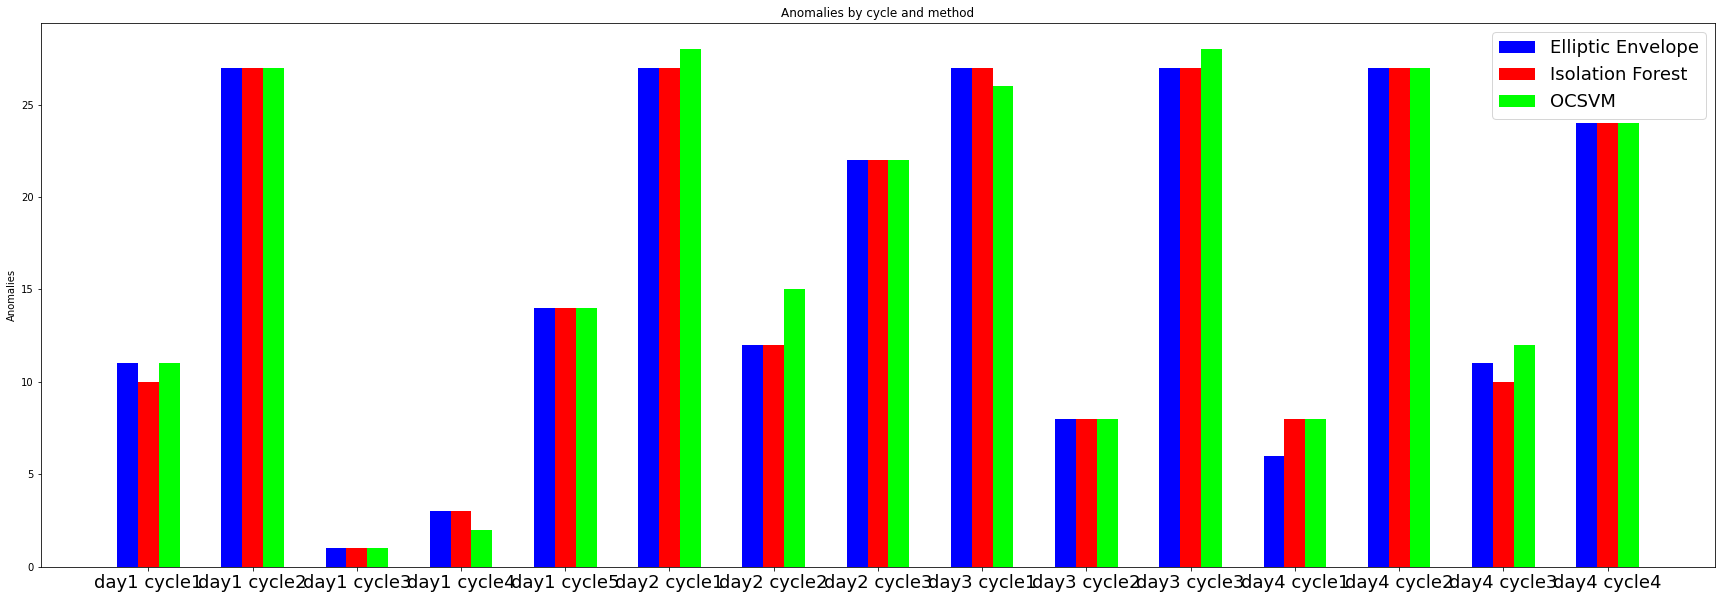

In [104]:
# Visualization of the different cycles for each method

colors = ['blue', 'red', 'lime']
labels = ['day1 cycle1', 'day1 cycle2', 'day1 cycle3', 'day1 cycle4', 'day1 cycle5', 'day2 cycle1', 'day2 cycle2', 'day2 cycle3', 'day3 cycle1', 'day3 cycle2', 'day3 cycle3', 'day4 cycle1', 'day4 cycle2', 'day4 cycle3', 'day4 cycle4']

legend = []


N = 15

ind = np.arange(N)  # the x locations for the groups
width = 0.2         # the width of the bars

fig = plt.figure(figsize = (30,10))
ax = fig.add_subplot(111)

rect_list = []

for i, (clf_name, _) in enumerate(classifiers.items()):
    L_anomalies_flattend = [item for sublist in L_anomalies[i] for item in sublist]
    rect = ax.bar(ind+i*width, L_anomalies_flattend, -width, color=colors[i], align='edge')
    rect_list.append(rect)
    legend.append(clf_name)


# add some
ax.set_ylabel('Anomalies')
ax.set_title('Anomalies by cycle and method')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels, fontsize=18)

ax.legend( (rect_list[0][0], rect_list[1][0], rect_list[2][0]), legend, fontsize=18)

plt.show()


This time, we notice that depending on the method we use to classify the data, the number of outliers per cycle  differs. It depends on the parameters chosen for each method, but it also depends on how the method works. These information will be taken into account when deciding which method should be used and optimized.

### 3. Anomaly detection in each window

Another idea was to try to identify outliers in each window. We would then sum up the number of outliers in each window and decide weather a window is an outlier or not depending on its number of outliers. We tried this method but because of the high dimensionnal space (at least 11 dimensions) and the low number of data (100 points per window), the results are not good.

### 4. Conclusion
  
The scale day-by-day allows us to have 4 datasets that have approximatly the same number of points, even if the shape of points is not very delimited.
  
The scale cycle-by-cycle is interesting : at this scale the shape of points is delimited and dense making the detection of anomalies easy even visually. However, there are cycles that have very few windows compared to others, for example day1-cycle3 has only 6 windows wheras day2-cycle1 has 181 windows. This adds errors to our anomaly detection.  
  
The scale window-by-window is too small to get something out of it.
  
**We choose to stick to the day-by-day anomaly detection**.

# Parameters optimisation
Given the visualization of anomalies in section `Choice of anomaly detection method`, Isolation Forest seems to detect outliers with better accuracy than the others. We choose this classifier and study the optimal parameters.

### 1. Choice of contamination ratio

contamination =  0.05


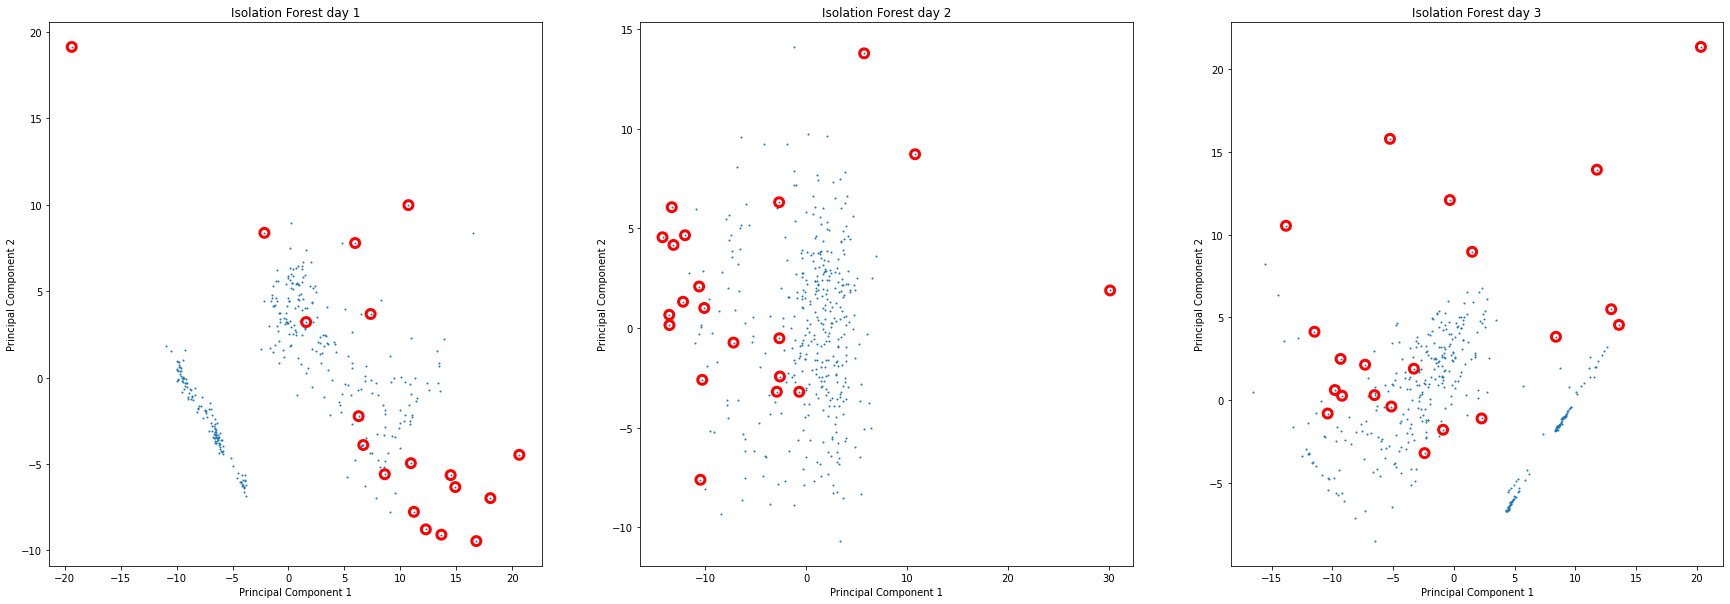

contamination =  0.1


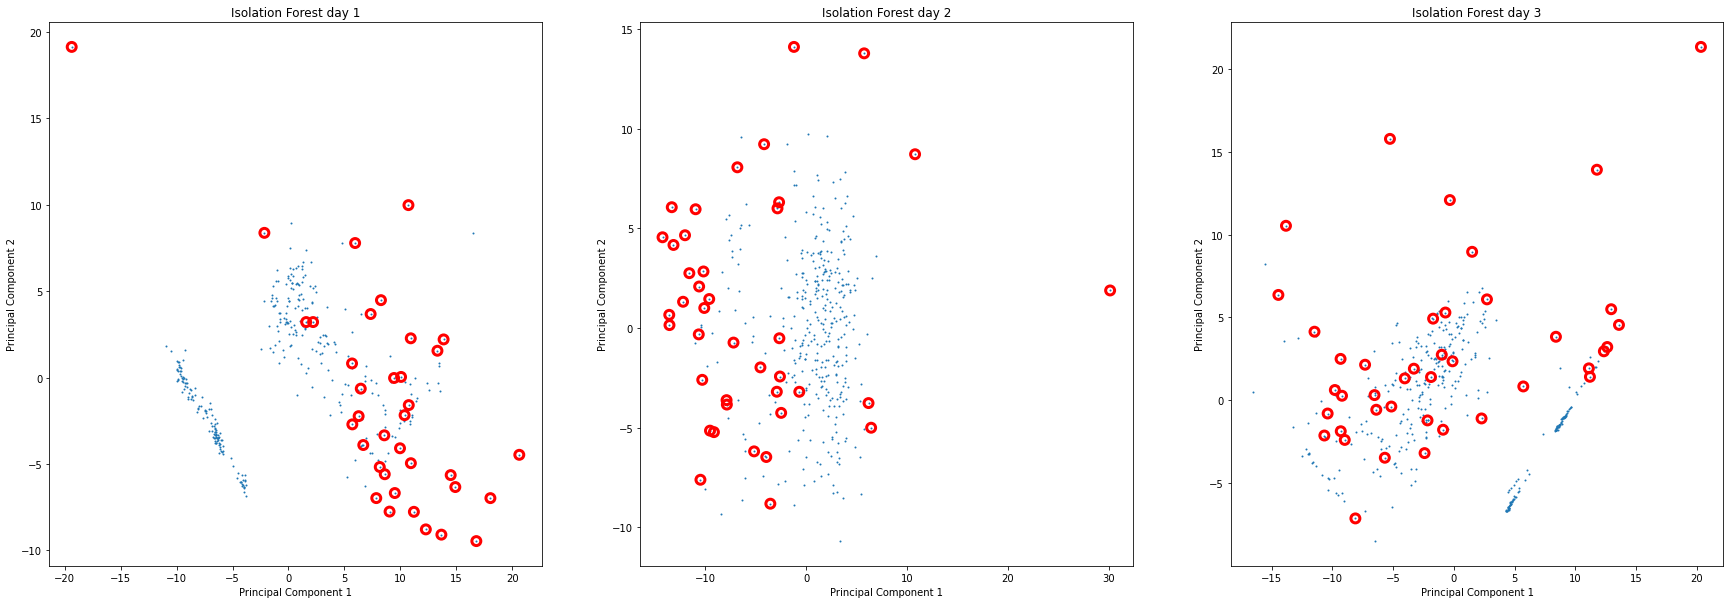

contamination =  0.2


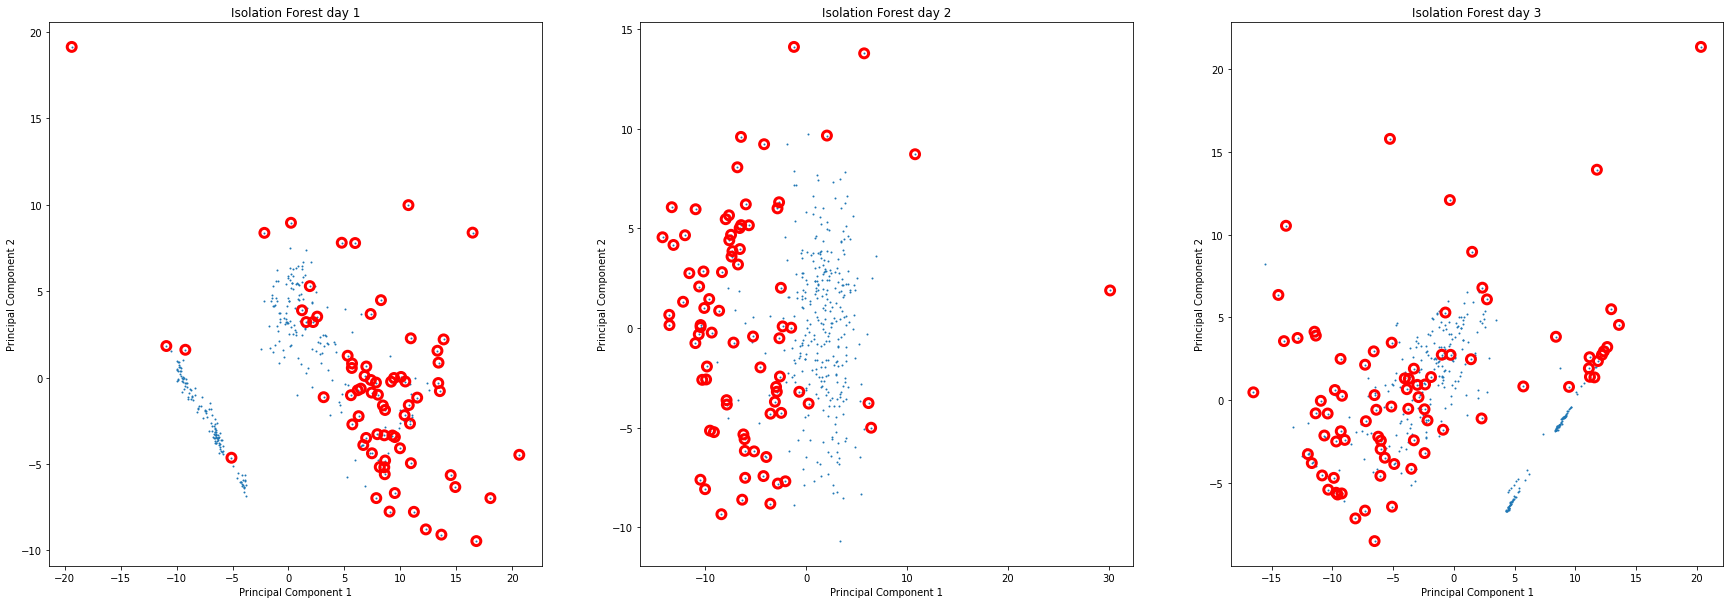

contamination =  0.25


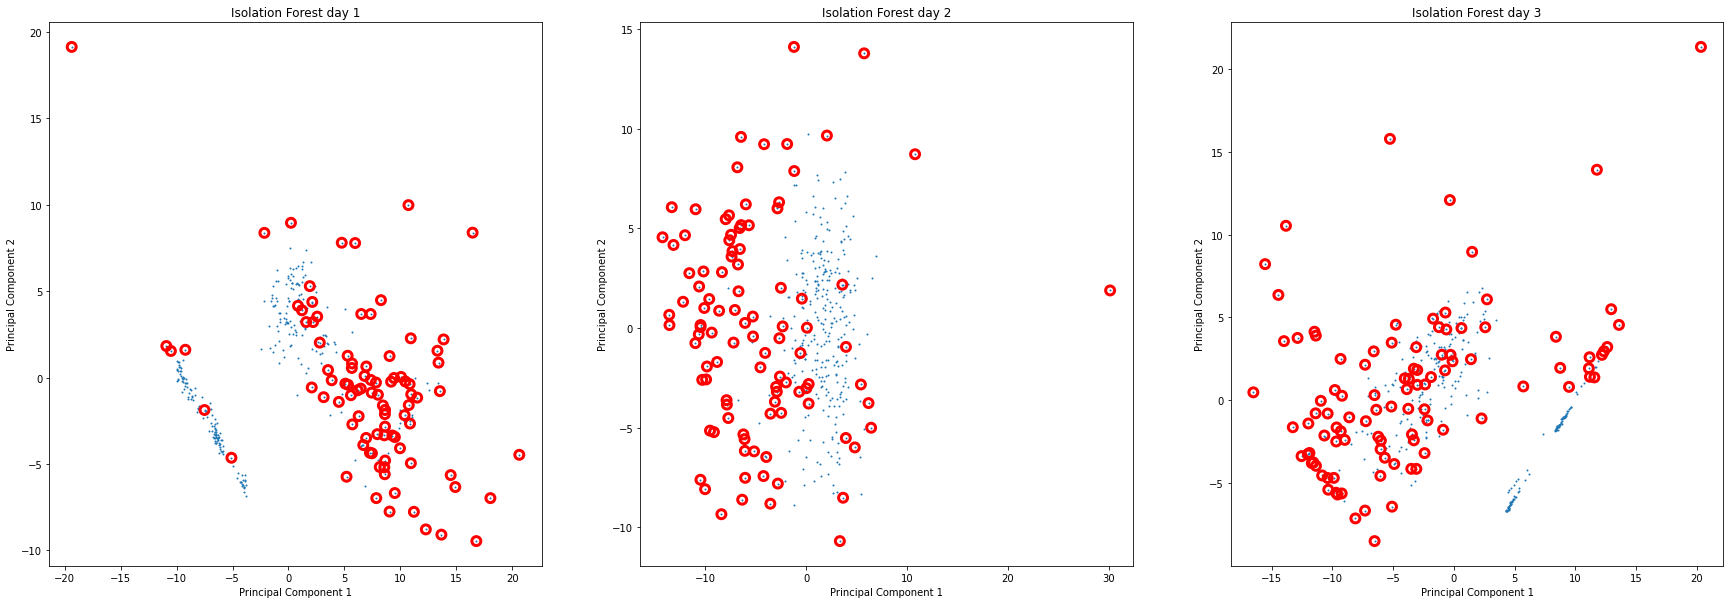

In [105]:
contamination = [0.05, 0.1, 0.2, 0.25]

for cont in contamination :
    print("contamination = ",cont)
    _, ax = plt.subplots(1,3,figsize=(30,10))
    for i,(day,df) in enumerate(data_reduced.groupby(['day'])):
        df2 = df.drop(columns=['day','cycle','window','day_cycle_window'])
        
        df_pca = do_pca(df2,2)

        classifier = IsolationForest(n_estimators=100, contamination=cont, bootstrap=False, n_jobs=4)
        classifier.fit(df2)
        pred = classifier.predict(df2)
        plot_pca(df_pca,"Isolation Forest"+" day "+ day,ax[i],pred=pred)
        
        if i == 2 :
            break
    
    plt.show()


The choice of contamination ratio is very subjective. We present the graphs above and let the client decide. For the n_estimators choice, we fix contamination to 0.1.

### 2. Choice of number of estimators

Nestimators =  10


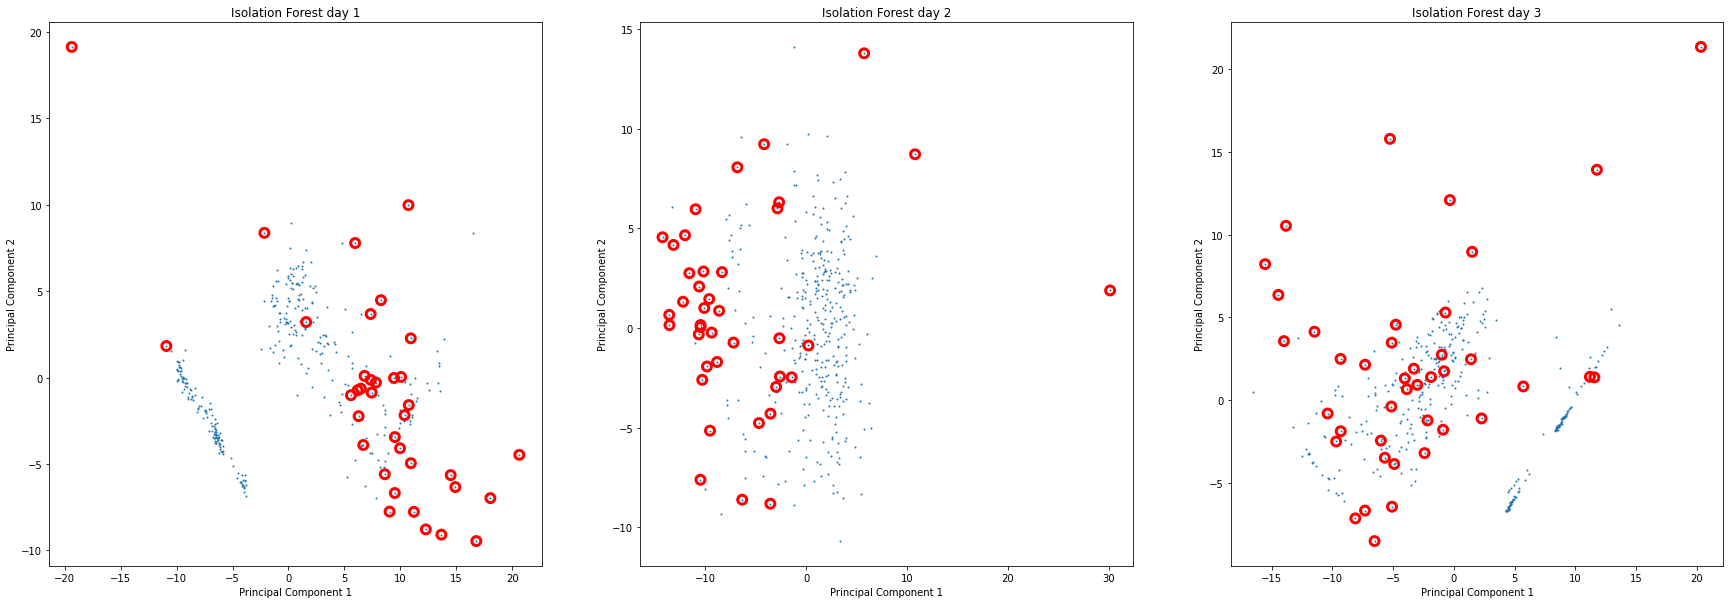

Nestimators =  50


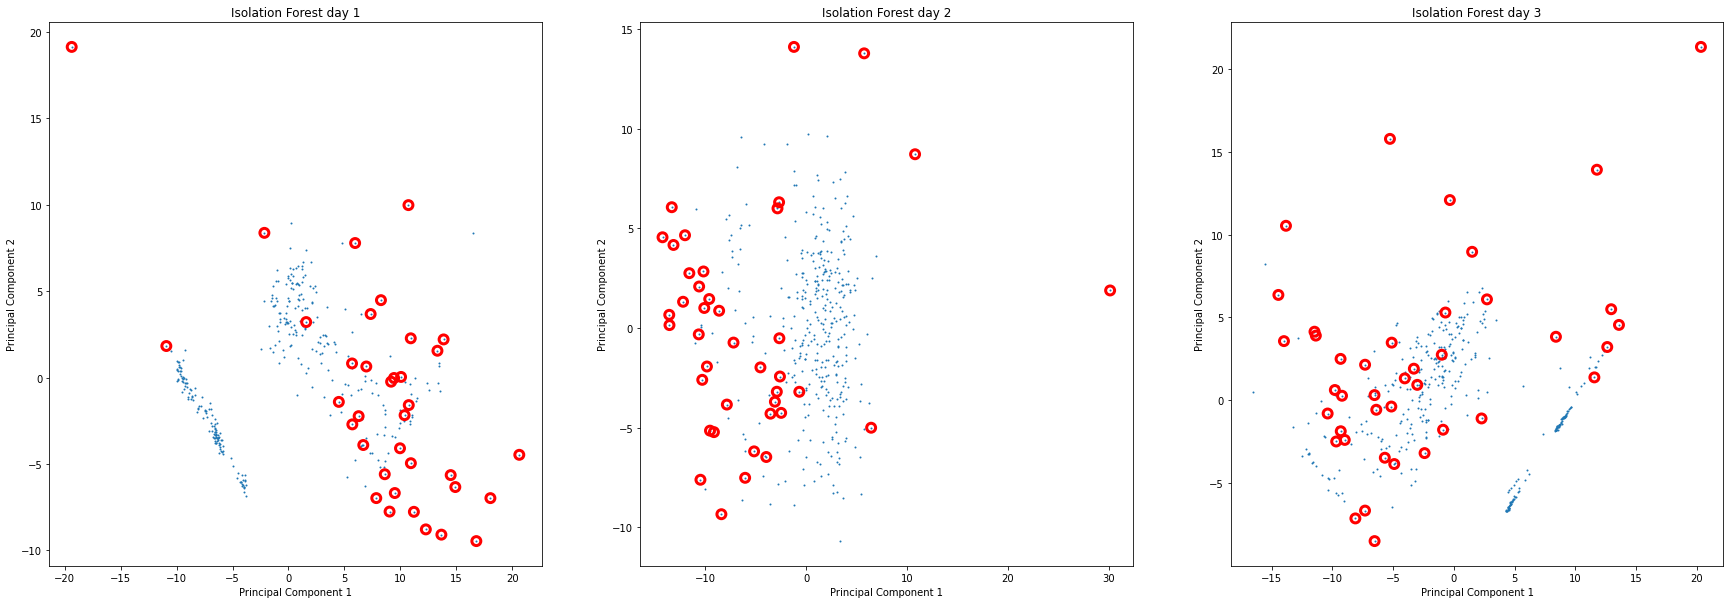

Nestimators =  100


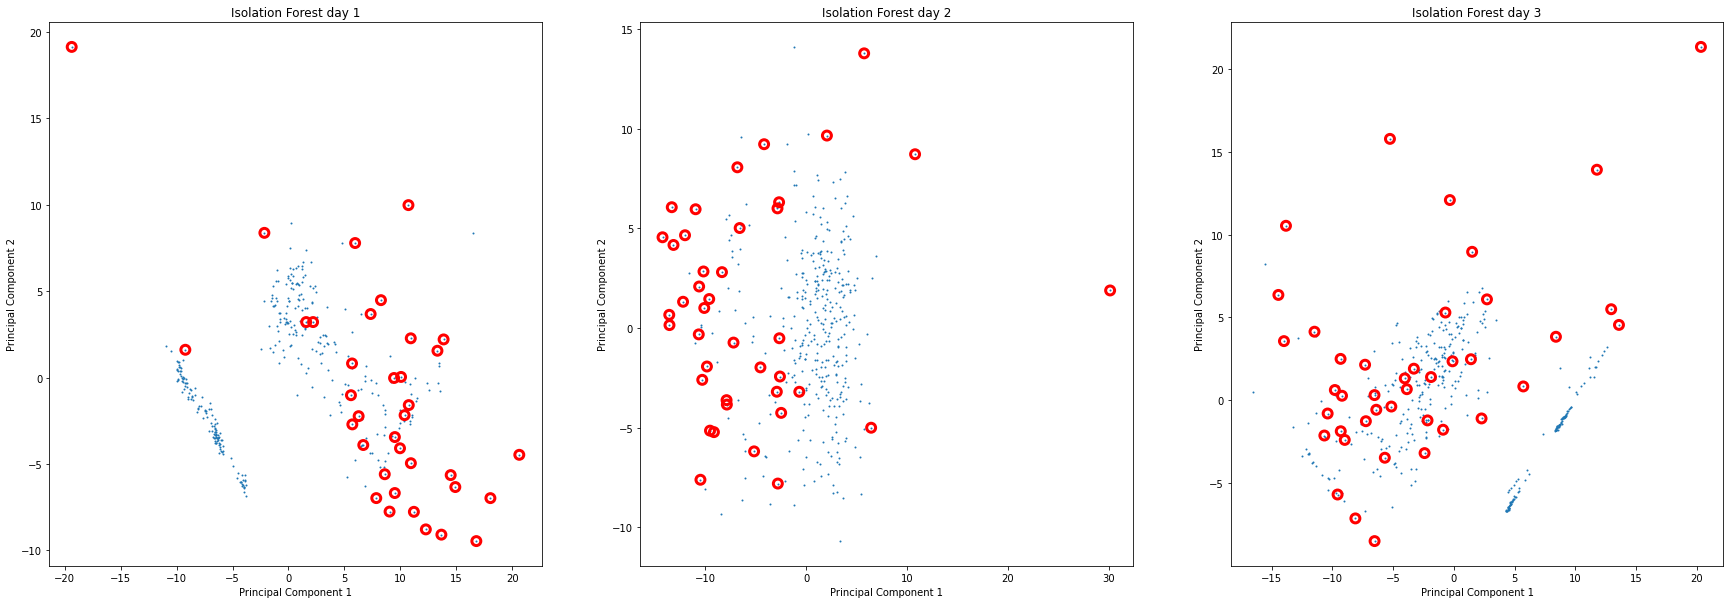

Nestimators =  200


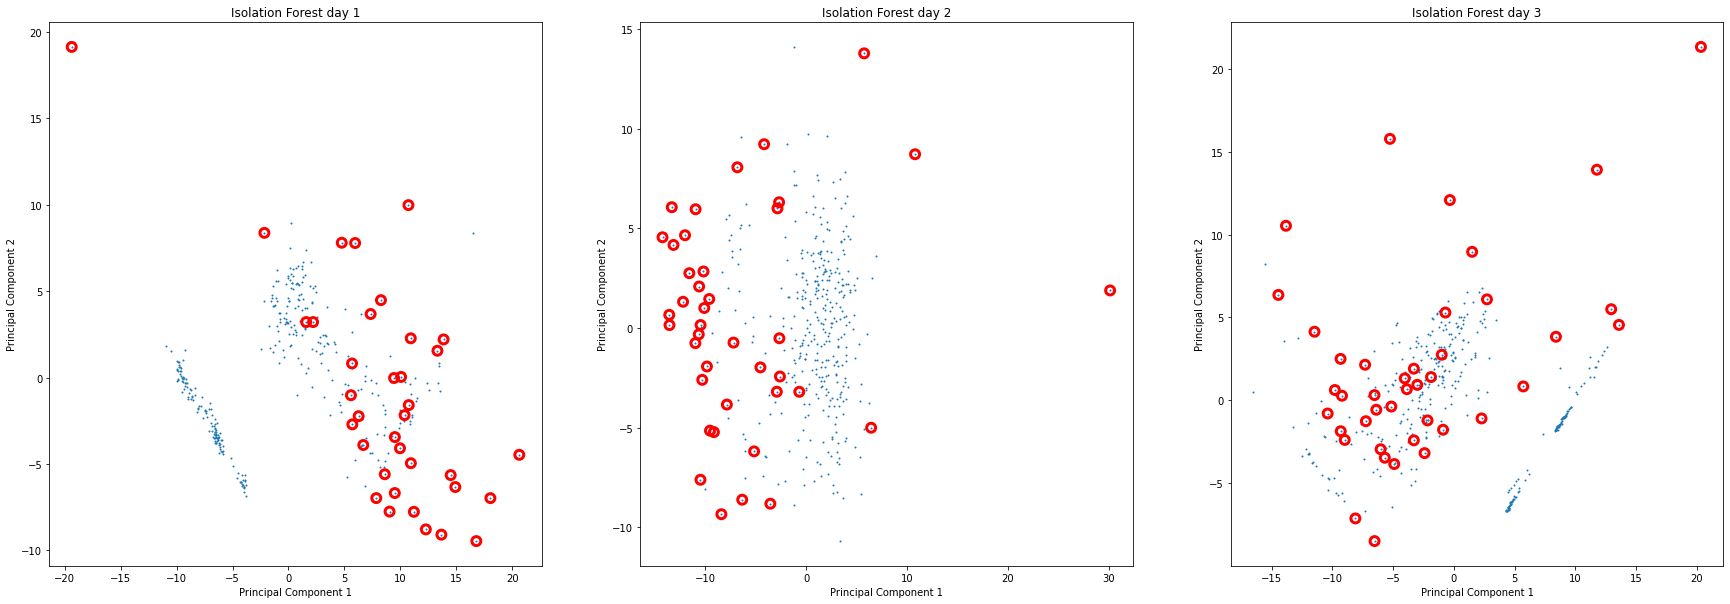

In [106]:
n_estimators = [10, 50, 100, 200]

for nest in n_estimators :
    print("Nestimators = ",nest)
    _, ax = plt.subplots(1,3,figsize=(30,10))
    for i,(day,df) in enumerate(data_reduced.groupby(['day'])):
        df2 = df.drop(columns=['day','cycle','window','day_cycle_window'])
        
        df_pca = do_pca(df2,2)

        classifier = IsolationForest(n_estimators=nest, contamination=0.1, bootstrap=False, n_jobs=4)
        classifier.fit(df2)
        pred = classifier.predict(df2)
        plot_pca(df_pca,"Isolation Forest"+" day "+ day,ax[i],pred=pred)
        
        if i == 2 :
            break
    
    plt.show()

For n_estimators > 30, results are the same. Theoretically this number has an impact on a test dataset (overfitting problem), however we don't need to split our data into train/test in this problem. We keep the number of estimators at 100.

### 3. Bootstrap or no bootstrap

bootstrap =  False


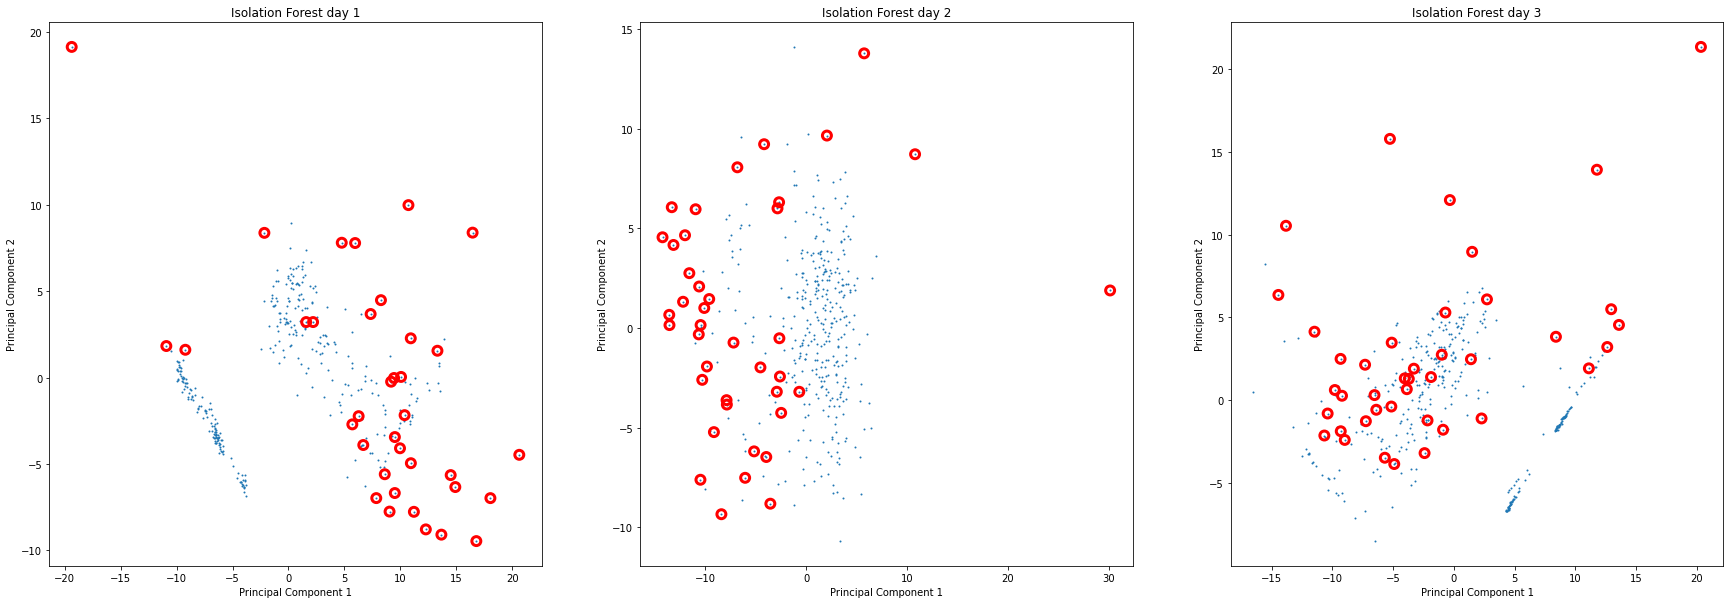

bootstrap =  True


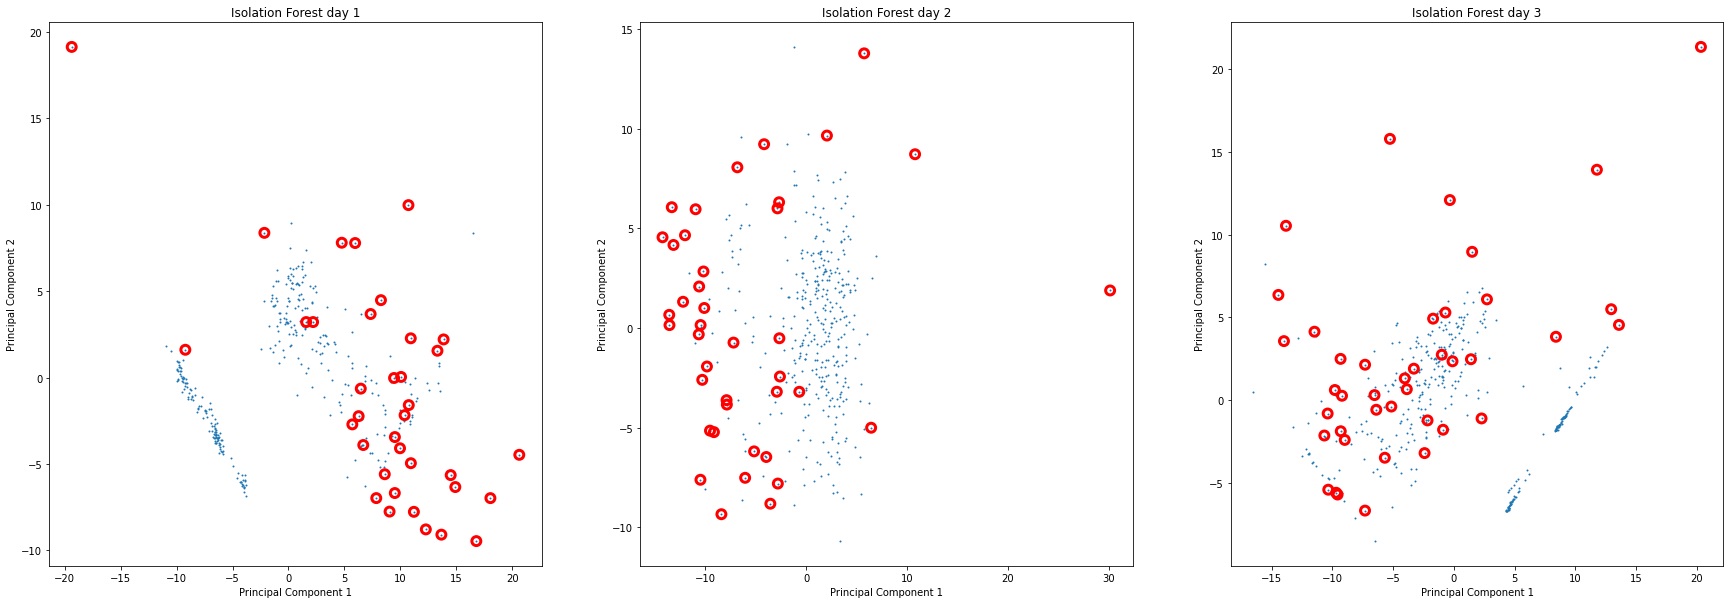

In [107]:
bootstrap = [False, True]

for bts in bootstrap :
    print("bootstrap = ",bts)
    _, ax = plt.subplots(1,3,figsize=(30,10))
    for i,(day,df) in enumerate(data_reduced.groupby(['day'])):
        df2 = df.drop(columns=['day','cycle','window','day_cycle_window'])
        
        df_pca = do_pca(df2,2)

        classifier = IsolationForest(n_estimators=100, contamination=0.1, bootstrap=bts, n_jobs=4)
        classifier.fit(df2)
        pred = classifier.predict(df2)
        plot_pca(df_pca,"Isolation Forest"+" day "+ day,ax[i],pred=pred)
        
        if i == 2 :
            break
        
    plt.show()

Using the bootstrapping technique is slightly better because it avoids swamping and masking. 

# Visulization of predictions

In [108]:
data[['day','cycle','window']] = data['day_cycle_window'].str.split(pat="_",expand=True)

#The final classifier
classifier = IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=4)

#Adding a 'pred' column of predictions
data_reduced['pred'] = None
for i,(day,df) in enumerate(data_reduced.groupby(['day'])):
        df2 = df.drop(columns=['day','cycle','window','day_cycle_window','pred'])

        classifier.fit(df2)
        pred = classifier.predict(df2)

        data_reduced.loc[data_reduced['day']==str(day),'pred'] = pred

pred_data = pd.merge(data,data_reduced[['day_cycle_window','pred']],how='left',on='day_cycle_window')
pred_data.columns = list(data.columns.values) + ['pred']


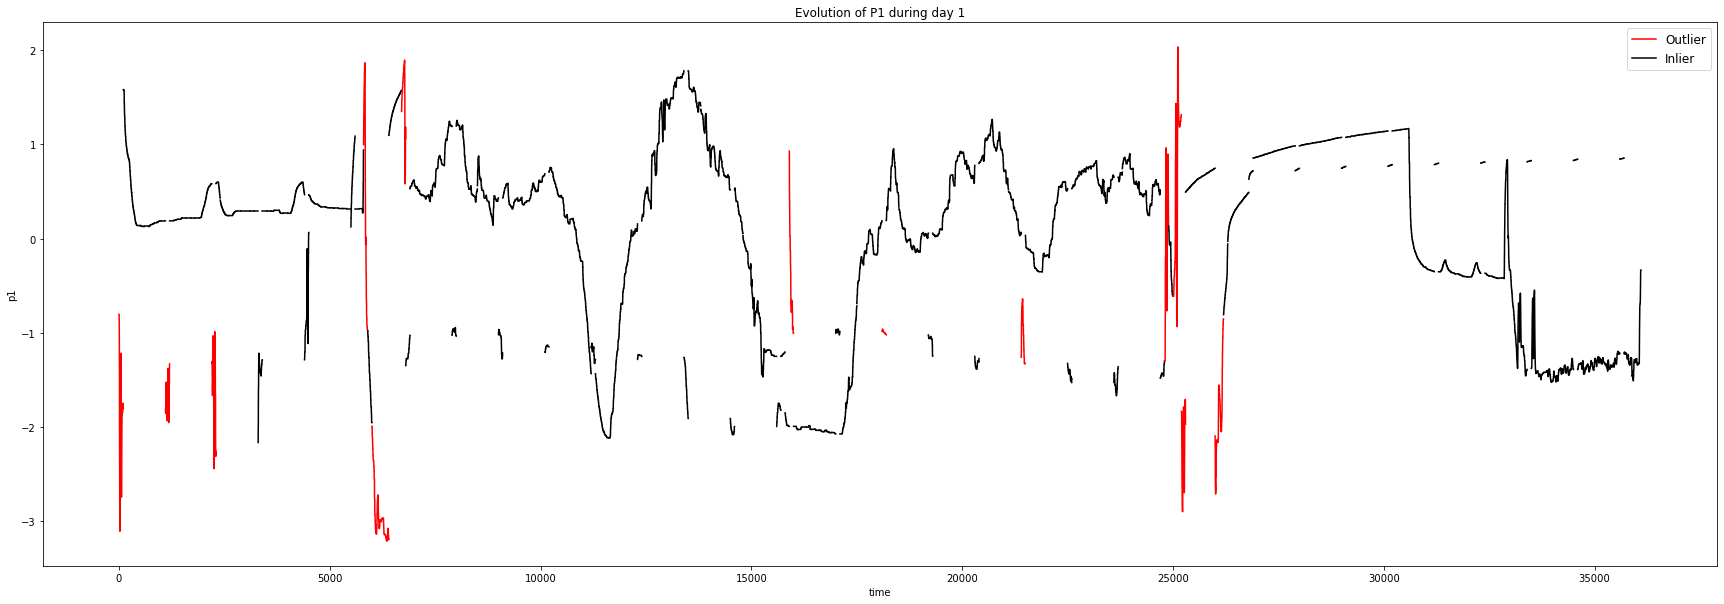

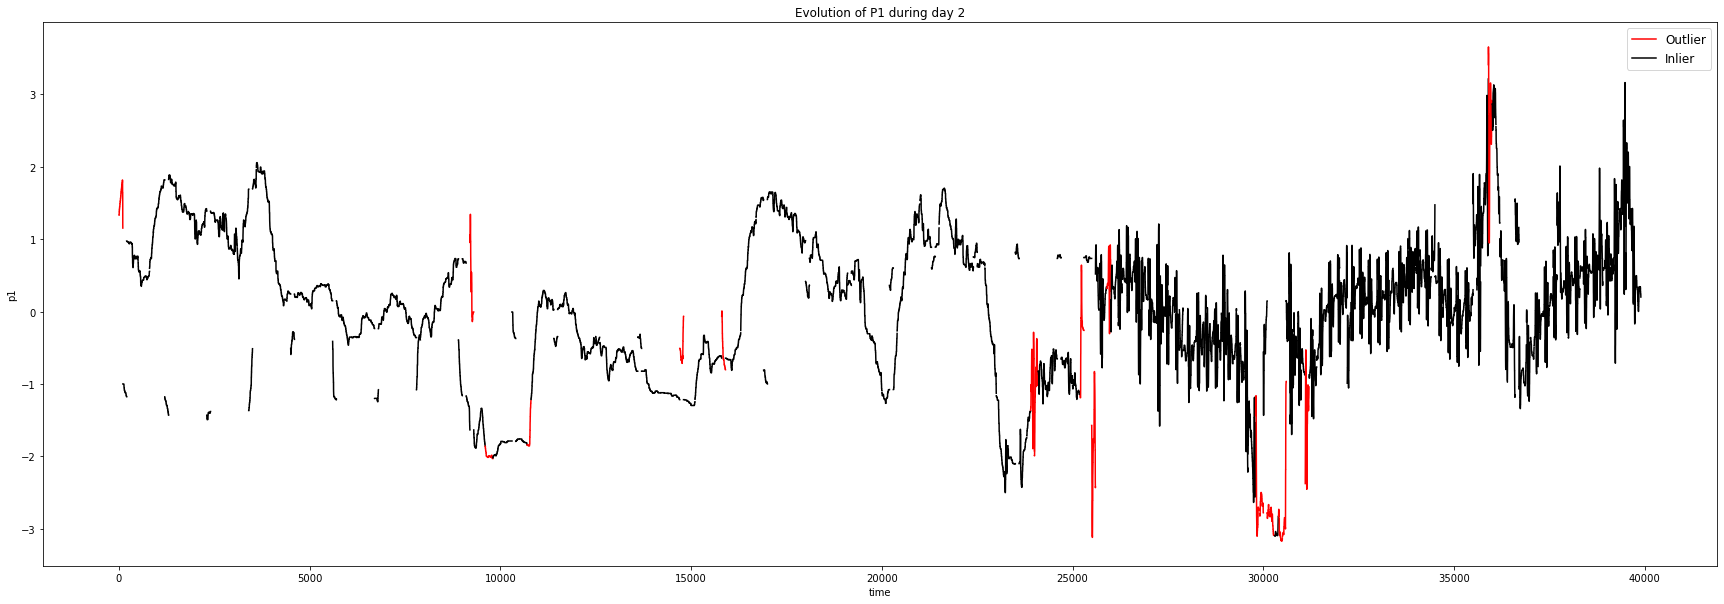

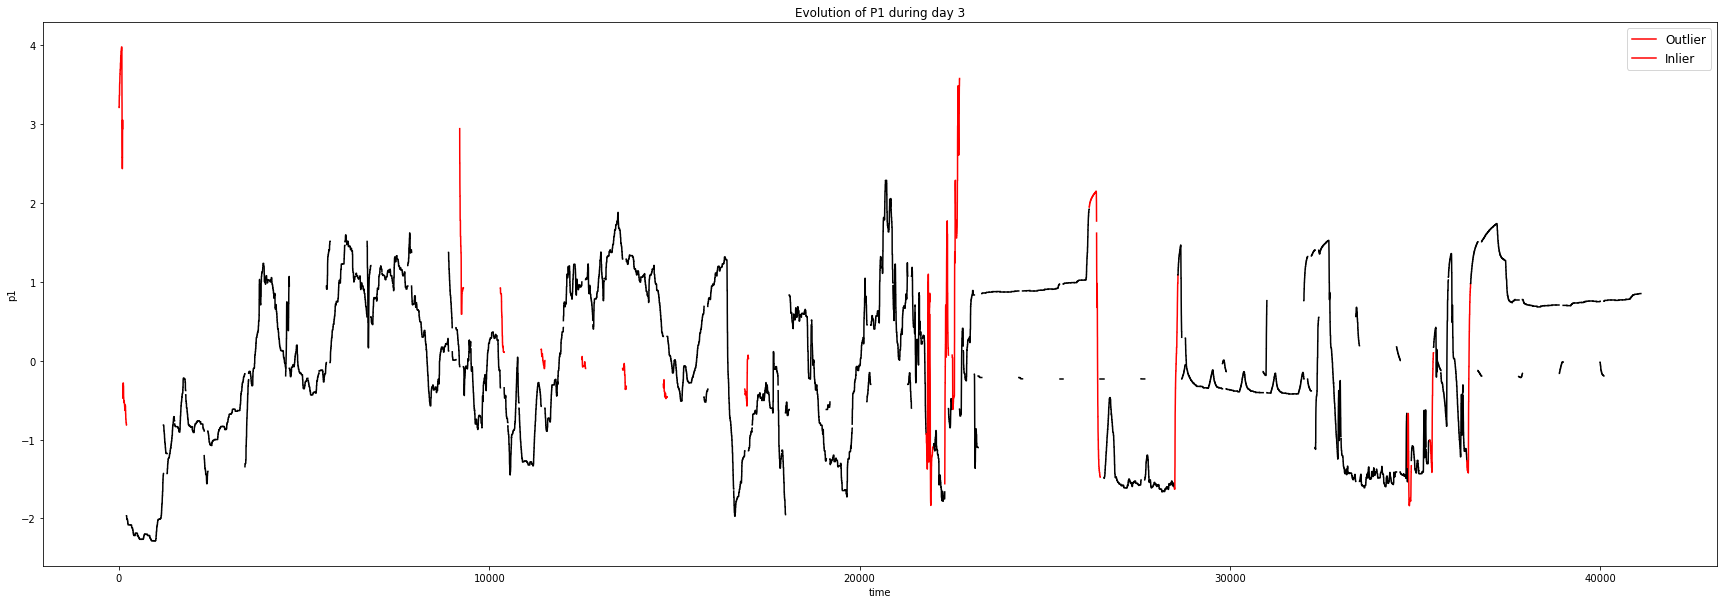

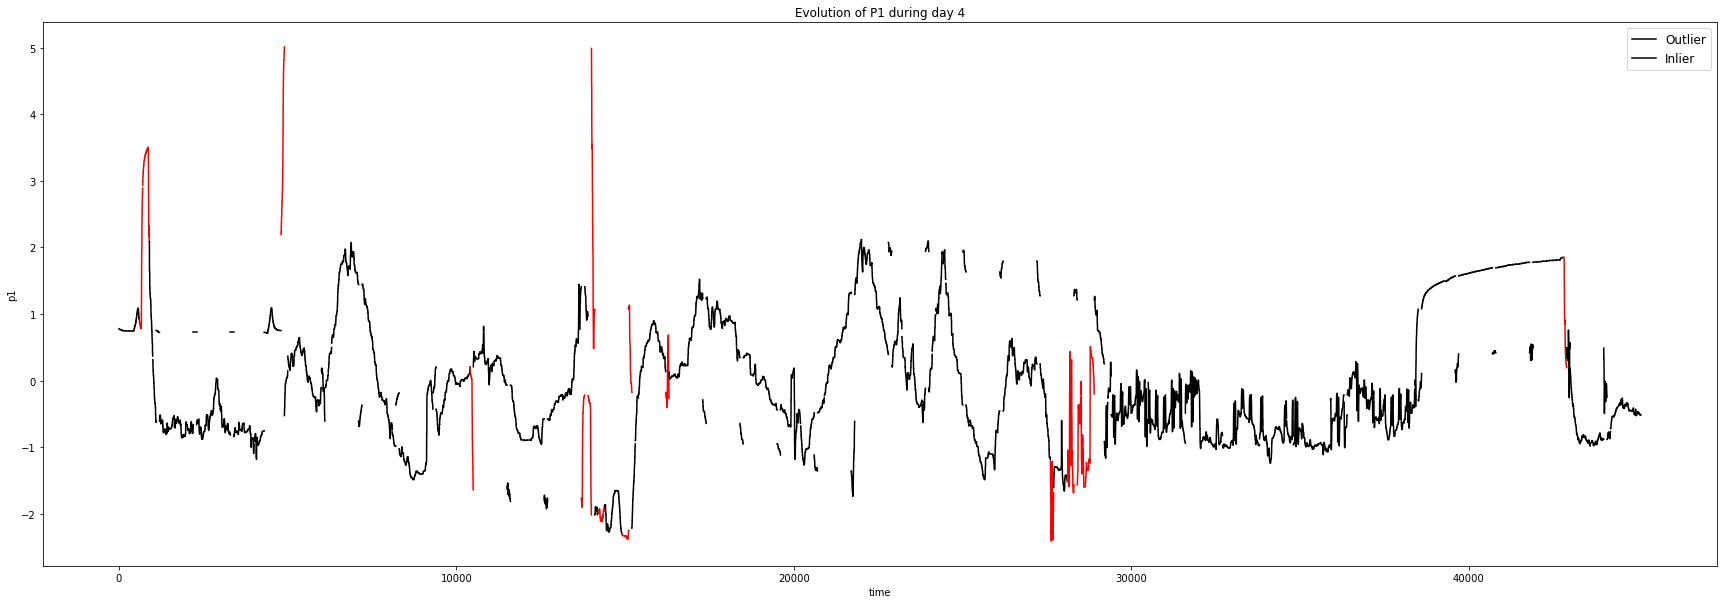

In [109]:
from matplotlib import cm

for day,df in pred_data.groupby('day') :
    plt.figure(figsize=(30,10))
    x = 0
    for window, df_ in df.groupby('day_cycle_window') :
        y = x+len(df_)
        pred = ('red' if df_['pred'].iloc[0] == -1 else 'black' )
        plt.plot(range(x,y),df_['p1'],c=pred)
        x = y

    plt.xlabel('time')
    plt.ylabel('p1')
    plt.title('Evolution of P1 during day '+day )
    plt.legend(['Outlier', 'Inlier'],fontsize='large')
    plt.show()


We observe that the predicted outliers ofter seem coherent (different than the rest). However sometimes windows that don't seem like outliers are predicted as so. This could mean that another feature other than P1 might show anomaly for that particular window. 

# Dimension reduction

The aim of this part is to briefly explore what could have been done using the recent lecture about Dimension Reduction.
We could have transformed the 100 points of each window as a separate feature (variable), this would make our dataset of size (nwindows, 100*11). 1100 is a lot of feature, we will have to do a dimensionality reduction.